# Import Modules

In [8]:
import os, sys
import pandas as pd
import numpy as np
import datetime as dt
from pprint import pprint
import csv
import itertools as it
from prettytable import PrettyTable
import matplotlib.pylab as plt
import seaborn as sns
import portion as P
from collections import namedtuple
import math

DataFrame = namedtuple('DataFrame', 'filename, df', defaults=tuple([None]*2))

pdir = os.path.abspath(os.path.join(os.getcwd(), '..'))  # for jupyter-notebook
sys.path.insert(1, pdir)
from myutils import *

%config InlineBackend.figure_format = 'retina'  # 提高 jupyter notebook 的圖形顯示解析度
# plt.style.use('ggplot')

pd.set_option('display.max_columns', 200)
# pd.set_option('display.max_rows', 200)

def set_data(df):
    df['seq'] = df['seq'].astype('Int32')
    df['rpkg'] = df['rpkg'].astype('Int8')
    df['frame_id'] = df['frame_id'].astype('Int32')
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['xmit_time'] = pd.to_datetime(df['xmit_time'])
    df['arr_time'] = pd.to_datetime(df['arr_time'])
    df['Timestamp_epoch'] = df['Timestamp_epoch'].astype('float32')
    df['xmit_time_epoch'] = df['xmit_time_epoch'].astype('float32')
    df['arr_time_epoch'] = df['arr_time_epoch'].astype('float32')
    df['lost'] = df['lost'].astype('boolean')
    df['excl'] = df['excl'].astype('boolean')
    df['latency'] = df['latency'].astype('float32')
    return df

In [2]:
# dfs_ul = []
# for (exp, traces), devices, schemes in zip(exps.items(), _devices, _schemes):
#     for trace in traces:
#         for j, (dev, schm) in enumerate(zip(devices, schemes)):
#             data = os.path.join(datadir, exp, dev, trace, 'data', 'udp_uplk_loss_latency.csv')
#             print(data, os.path.isfile(data))
#             df = pd.read_csv(data)
#             df = set_data(df)
#             # dfs_ul.append(DataFrame(data, df.copy()))
#             dfs_ul.append(DataFrame(data, None))
# print(len(dfs_ul))

# dfs_dl = []
# for (exp, traces), devices, schemes in zip(exps.items(), _devices, _schemes):
#     for trace in traces:
#         for j, (dev, schm) in enumerate(zip(devices, schemes)):
#             data = os.path.join(datadir, exp, dev, trace, 'data', 'udp_dnlk_loss_latency.csv')
#             print(data, os.path.isfile(data))
#             df = pd.read_csv(data)
#             df = set_data(df)
#             # dfs_dl.append(DataFrame(data, df.copy()))
#             dfs_dl.append(DataFrame(data, None))
# print(len(dfs_dl))

# dfs_ho = []
# for (exp, traces), devices, schemes in zip(exps.items(), _devices, _schemes):
#     for trace in traces:
#         for j, (dev, schm) in enumerate(zip(devices, schemes)):
#             path = os.path.join(datadir, exp, dev, trace, 'data')
#             data = os.path.join(path, [s for s in os.listdir(path) if s.startswith('diag_log_') and s.endswith('_rrc.csv')][0])
#             print(data, os.path.isfile(data))
#             df = pd.read_csv(data)
#             df, _, _ = mi_parse_ho(df, tz=8)
#             df['ho_type0'] = df['ho_type'].astype('string')
#             df.loc[df['cause'].notna(), 'ho_type0'] = df['ho_type'].astype('string') + '_' + df['cause'].astype('string')
#             df['ho_type0'] = df['ho_type0'].astype('category')
#             # dfs_ho.append(DataFrame(data, df.copy()))
#             dfs_ho.append(DataFrame(data, None))
# print(len(dfs_ho))

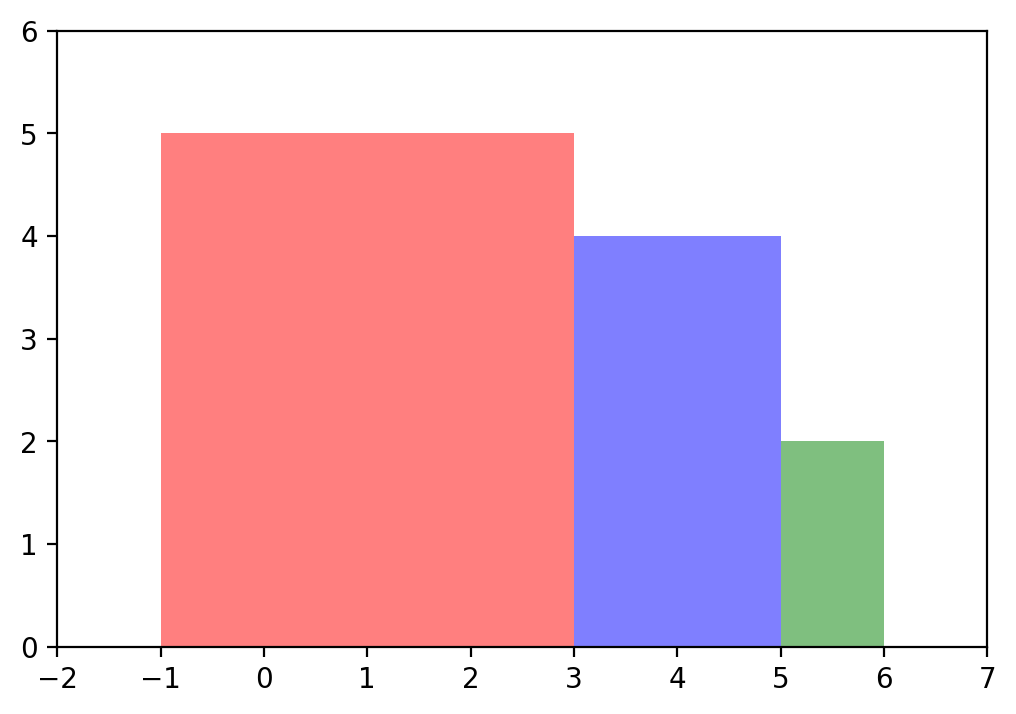

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 畫布大小
fig, ax = plt.subplots(figsize=(6, 4))

# 繪製長方形
rect1 = patches.Rectangle((-1, 0), 4, 5, ec=None, fc='r', alpha=0.5)  # 左下角座標點, 寬度, 高度, 邊界顏色, 填滿顏色
rect2 = patches.Rectangle((3, 0), 2, 4, ec=None, fc='b', alpha=0.5)
rect3 = patches.Rectangle((5, 0), 1, 2, ec=None, fc='g', alpha=0.5)

# 設定x、y軸範圍
plt.xlim(-2, 7)
plt.ylim(0, 6)

ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)

# 顯示圖形
plt.show()

# Go

In [4]:
datadir = "/Users/jackbedford/Desktop/MOXA/Code/data"
exps = {
    "2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q": ['#{:02d}'.format(i+1) for i in range(12)],
    "2023-04-01/_Bandlock_Udp_B1_B3_B7_B8_RM500Q": ['#{:02d}'.format(i+1) for i in range(6)],
    "2023-04-01/_Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q": ['#{:02d}'.format(i+1) for i in range(4)],
    # "2023-04-01/_Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q": ['#{:02d}'.format(i+1) for i in range(1)],
}
_devices = [
    ['qc00','qc02','qc03'],
    ['qc00','qc01','qc02','qc03'],
    ['qc00','qc01','qc02','qc03'],
    # ['qc00'],
]
_schemes = [
    ['B1','B7','B8'],
    ['B1','B3','B7','B8'],
    ['B1B3','B1B8','LTE','All'],
    # ['B1B3'],
]

In [21]:
ImpactScope = {
    'LTE_HO': (0.35, 0.55),
    'MN_HO': (1.25, 1.6),
    'SN_HO': (0.85, 1.25),
    'SN_Setup': (0.35, 1.5),
    'SN_Rel': (0.05, 0.1),
    'SN_Rel_MN_HO': (1.15, 0.7),
    'SCG_Failure_t310-Expiry (0)': (1.65, 1.2),
    'SCG_Failure_synchReconfigFailureSCG (3)': (0.05, 0.05),
    'MCG_Failure_reconfigurationFailure (0)': (2, 2),
    'MCG_Failure_handoverFailure (1)': (0.7, 1.25),
    'MCG_Failure_otherFailure (2)': (5.7, 1.25),
    'NAS_Recovery_otherFailure (2)': (0.75, 1.65)}

def setup_profile(df, tag, start, end, mode='ul', sec=1, left=pd.Timestamp.min, right=pd.Timestamp.max):
    if pd.notna(end):
        midpoint = start + (end - start) / 2
        intv = P.closed(max(start-pd.Timedelta(seconds=ImpactScope[tag][0]), left), min(end+pd.Timedelta(seconds=ImpactScope[tag][1]), right))
    else:
        midpoint = start
        intv = P.closed(max(start-pd.Timedelta(seconds=ImpactScope[tag][0]), left), min(start+pd.Timedelta(seconds=ImpactScope[tag][1]), right))
    
    # print(start, end, midpoint, sep='\n')
    # print(start, end, midpoint)
    
    if mode == 'ul':
        df_plot = df.query('xmit_time >= @intv.lower & xmit_time <= @intv.upper').copy().reset_index(drop=True)
        df_plot['rel_time'] = (df_plot['xmit_time'] - midpoint).dt.total_seconds()
    elif mode == 'dl':
        df_plot = df.query('arr_time >= @intv.lower & arr_time <= @intv.upper').copy().reset_index(drop=True)
        df_plot['rel_time'] = (df_plot['arr_time'] - midpoint).dt.total_seconds()
    else: # 'pyl'
        df_plot = df.query('Timestamp >= @intv.lower & Timestamp <= @intv.upper').copy().reset_index(drop=True)
        df_plot['rel_time'] = (df_plot['Timestamp'] - midpoint).dt.total_seconds()
    df_plot['cat_id'] = ((df_plot['rel_time'] + 0.005) // 0.01) * 0.01
    # display(df_plot)

    ts_group = df_plot.groupby(['cat_id'])
    table = ts_group['lost'].agg(['count','sum','mean']).copy().reset_index()
    table = table.rename(columns={'count':'tx_count', 'sum':'lost', 'mean':'PLR'})
    table['PLR'] = table['PLR'] * 100
    # display(table)
    return table, intv

def merge_profile(tables, intrs):
    intr = np.mean(intrs)
    table = pd.DataFrame(columns=['cat_id','tx_count','lost','PLR'])
    table['cat_id'] = table['cat_id'].astype('float32')
    table['tx_count'] = table['tx_count'].astype('Int32')
    table['lost'] = table['lost'].astype('Int32')
    table['PLR'] = table['PLR'].astype('float32')
    for i in range(len(tables)):
        _table = tables[i].copy()
        table = table.merge(_table, on=['cat_id'], how='outer').fillna(0)
        table['tx_count'] = table['tx_count_x'] + table['tx_count_y']
        table['lost'] = table['lost_x'] + table['lost_y']
        table['PLR'] = 0
        table = table[['cat_id','tx_count','lost','PLR']]
    table['PLR'] = table['lost'] / (table['tx_count'] + 1e-9) * 100
    table = table[['cat_id','tx_count','lost','PLR']].copy().sort_values(by=['cat_id']).reset_index(drop=True)
    return table, intr

def plot_profile(table, intr=0, title='', mode='lost', xlim=0, path='', flow='ul', stable_plr=0, plr=0):
    fig, ax = plt.subplots(figsize=(6, 4))
    if flow == 'ul':
        ax.set_title(f'Uplink: {title}')
    else: # 'dl'
        ax.set_title(f'Downlink: {title}')
    if xlim == 0:
        ax.set_xlim(table.iat[0, table.columns.get_loc('cat_id')], table.iat[-1, table.columns.get_loc('cat_id')])
    else:
        ax.set_xlim(-xlim, xlim)
    # ax.set_xlim([(intv.lower-midpoint).total_seconds(), (intv.upper-midpoint).total_seconds()])
    if mode == 'lost':
        ax.bar(table['cat_id'], table['lost'], width=0.01, alpha=0.97)
        ax.set_ylabel('Lost Number')
    if mode == 'plr':
        ax.bar(table['cat_id'], table['PLR'], width=0.01, alpha=0.97)
        ax.set_ylabel('Packet Loss Rate (%)')
        ax.axhline(stable_plr, color='tab:pink', linestyle='--', label='Stable PLR')
        # ax.axhline(plr, color='tab:orange', linestyle='--', label=f'{title} PLR')
        ax.text(-1.078*xlim, plr, '{:.2f}'.format(plr), ha='center', fontweight='bold', fontsize=10, color='tab:orange')
        ax.legend()
        bleft = -ImpactScope[title][0]
        bright = ImpactScope[title][1]
        rect1 = patches.Rectangle((bleft, 0), bright-bleft, plr, ec=None, fc='#ffbc00', alpha=0.5)  # 左下角座標點, 寬度, 高度, 邊界顏色, 填滿顏色
        ax.add_patch(rect1)
        # ax.set_ylim(top=105)
    intr /= 2
    # ax.axvline((start-midpoint).total_seconds(), color='tab:red', alpha=0.5)
    # ax.axvline((end-midpoint).total_seconds(), color='tab:red', alpha=0.5)
    ax.axvline(-intr, color='tab:red', alpha=0.5)
    ax.axvline(intr, color='tab:red', alpha=0.5)
    ax.set_xlabel('Relative Timestamp (sec)')
    plt.gcf().autofmt_xdate()
    plt.savefig(os.path.join(path, f'{title}_{flow.upper()}_{mode}.png'), bbox_inches='tight', dpi=300)
    plt.show()

def plot_intrs(data, tag, path=''):
    data = [s*1000 for s in data]
    
    # Plot the violin plot
    fig, ax = plt.subplots(figsize=(6, 1.5))
    ax.violinplot(data, positions=None, vert=False, quantiles=[0.25, 0.5, 0.75])

    # Calculate and plot the mean and median values
    mean = np.mean(data)
    ax.axvline(mean, color='r', linestyle='--', label='Mean')
    ax.text(mean, 0.58, '{:.1f}'.format(mean), ha='center', fontweight='bold', fontsize=10, color='r')
    ax.set_xlim(left=0)
    ax.set_yticks([])
    ax.set_title(tag)
    ax.set_xlabel('Handover Interruption Time (ms)')

    # Add legend and title
    ax.legend()
    
    # Show the plot
    plt.savefig(os.path.join(path, f'{tag}_intr_dist.png'), bbox_inches='tight', dpi=300)
    plt.show()

In [22]:
wsize = 0.2

## Downlink

### Arrival Time

In [23]:
sorter = ['LTE_HO','MN_HO','SN_HO','MNSN_HO','SN_Rel','SN_Setup','SN_Rel_MN_HO','SN_Setup_MN_HO',
          'SCG_Failure_t310-Expiry (0)','SCG_Failure_randomAccessProblem (1)','SCG_Failure_rlc-MaxNumRetx (2)','SCG_Failure_synchReconfigFailureSCG (3)',
          'SCG_Failure_scg-ReconfigFailure (4)','SCG_Failure_srb3-IntegrityFailure (5)','SCG_Failure_other-r16 (6)',
          'MCG_Failure_reconfigurationFailure (0)','MCG_Failure_handoverFailure (1)','MCG_Failure_otherFailure (2)',
          'NAS_Recovery_reconfigurationFailure (0)','NAS_Recovery_handoverFailure (1)','NAS_Recovery_otherFailure (2)']

D = {}
for tag in sorter:
    D[tag] = {'tables': [], 'intrs': [], 'count': []}
stable_pkt = 0
stable_loss = 0
for (exp, traces), devices, schemes in zip(exps.items(), _devices, _schemes):
    for trace in traces:
        for j, (dev, schm) in enumerate(zip(devices, schemes)):
            ## read downlink
            data = os.path.join(datadir, exp, dev, trace, 'data', 'udp_dnlk_loss_latency.csv')
            print(data, os.path.isfile(data))
            df_dl = pd.read_csv(data)
            df_dl = set_data(df_dl)
            ## read handover
            path = os.path.join(datadir, exp, dev, trace, 'data')
            data = os.path.join(path, [s for s in os.listdir(path) if s.startswith('diag_log_') and s.endswith('_rrc.csv')][0])
            print(data, os.path.isfile(data))
            df_ho = pd.read_csv(data)
            df_ho, _, _ = mi_parse_ho(df_ho, tz=8)
            df_ho['ho_type0'] = df_ho['ho_type'].astype('string')
            df_ho.loc[df_ho['cause'].notna(), 'ho_type0'] = df_ho['ho_type'].astype('string') + '_' + df_ho['cause'].astype('string')
            df_ho['ho_type0'] = df_ho['ho_type0'].astype('category')
            ## start processing
            df = df_ho[~np.in1d(df_ho['ho_type'], ['Conn_Setup', 'Conn_Rel'])].copy().reset_index(drop=True)
            A = {}
            for tag in sorter:
                A[tag] = {'tables': [], 'intrs': []}
            _intv = P.singleton(pd.Timestamp.min)
            for i, row in df.iterrows():
                prior_row = df.iloc[i-1] if i != 0 else None
                post_row = df.iloc[i+1] if i != len(df)-1 else None
                ### peek the next event: avoid MN/LTE HO overlaps with handoverFailure
                if i != len(df)-1 and pd.notna(row.end) and row.end > post_row.start:
                    print(i, row.start, row.end, row.ho_type, row.cause)
                    print(i+1, post_row.start, post_row.end, post_row.ho_type, post_row.cause)
                    continue
                if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
                    prior_row = df.iloc[i-2] if i > 1 else None
                ### basic timestamp
                tag = row.ho_type0
                start, end = row.start, row.end
                intr = row.intr if pd.notna(row.intr) else 0
                ### set left, right limit
                if prior_row is not None:
                    if pd.notna(prior_row.end):
                        # left = prior_row.end
                        left = prior_row.end + (start - prior_row.end) / 2
                    else:
                        # left = prior_row.start
                        left = prior_row.start + (start - prior_row.start) / 2
                else:
                    left = pd.Timestamp.min
                if post_row is not None:
                    if pd.notna(end):
                        # right = post_row.start
                        right = end + (post_row.start - end) / 2
                    else:
                        # right = post_row.start
                        right = start + (post_row.start - start) / 2
                else:
                    right = pd.Timestamp.max
                ### 
                table, intv = setup_profile(df_dl, tag, start, end, mode='dl', sec=wsize, left=left, right=right)
                # print(intr)
                # display(table)
                A[tag]['tables'].append(table)
                A[tag]['intrs'].append(intr)
            ### count stable loss, pkt
                if i == 0:
                    lower = pd.Timestamp.min
                    upper = intv.lower
                else:
                    lower = _intv.upper
                    upper = intv.lower
                df_tmp = df_dl.query('arr_time > @lower & arr_time <= @upper').copy().reset_index(drop=True)
                stable_pkt += len(df_tmp)
                stable_loss += sum(df_tmp['lost'])
                _intv = intv
            lower = _intv.upper
            upper = pd.Timestamp.max
            df_tmp = df_dl.query('arr_time > @lower & arr_time <= @upper').copy().reset_index(drop=True)
            stable_pkt += len(df_tmp)
            stable_loss += sum(df_tmp['lost'])
            for tag in sorter:
                if len(A[tag]['tables']) == 0:
                    continue
                table, intr = merge_profile(A[tag]['tables'], A[tag]['intrs'])
                # print('HO Count:', len(df))
                D[tag]['tables'].append(table)
                D[tag]['intrs'] = [*D[tag]['intrs'], *A[tag]['intrs']]
                D[tag]['count'].append(len(A[tag]['tables']))
            stable_plr = stable_loss / (stable_pkt + 1e-9) * 100
            print(stable_loss, stable_pkt, round(stable_plr, 3))

/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#01/data/udp_dnlk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#01/data/diag_log_qc00_2023-03-16_19-23-29_rrc.csv True
0 118909 0.0
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc02/#01/data/udp_dnlk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc02/#01/data/diag_log_qc02_2023-03-16_19-23-29_rrc.csv True
0 221289 0.0
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc03/#01/data/udp_dnlk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc03/#01/data/diag_log_qc03_2023-03-16_19-23-29_rrc.csv True
0 318251 0.0
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#02/data/udp_dnlk_loss_latency.csv T

LTE_HO
Avg Duration: 0.03025620725971681 seconds
HO Count: 135
Avg PLR: 6.335128286347548 %


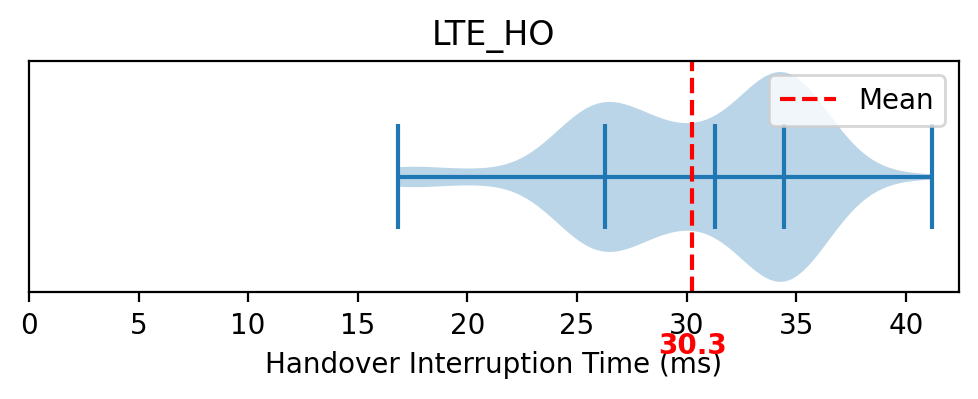

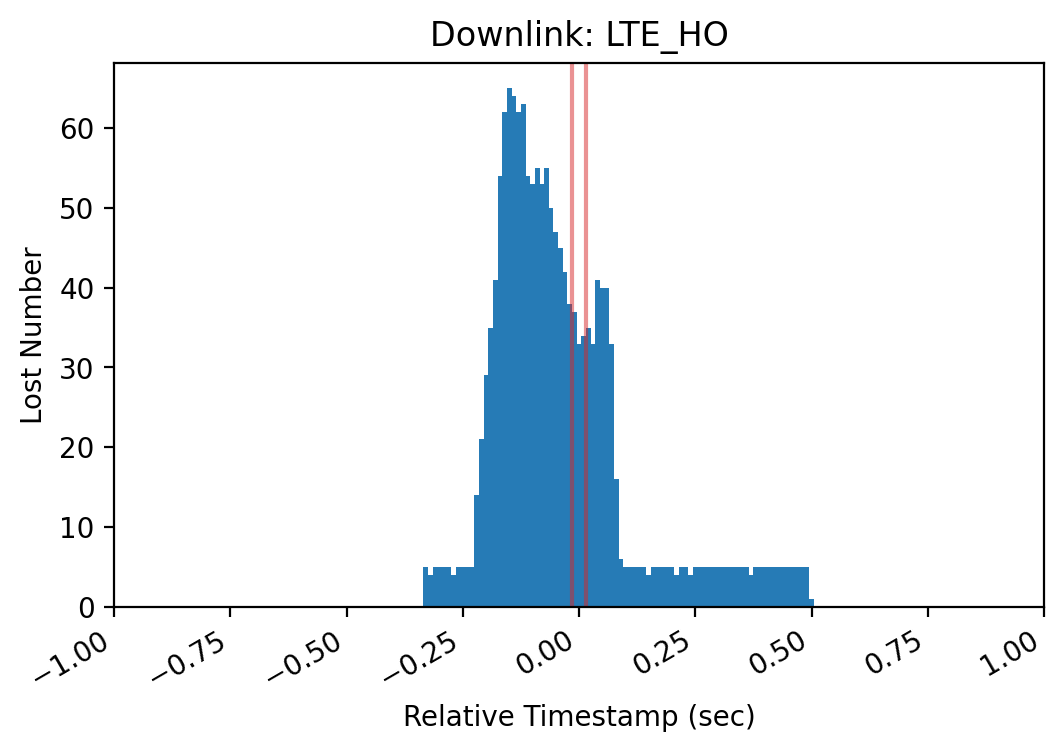

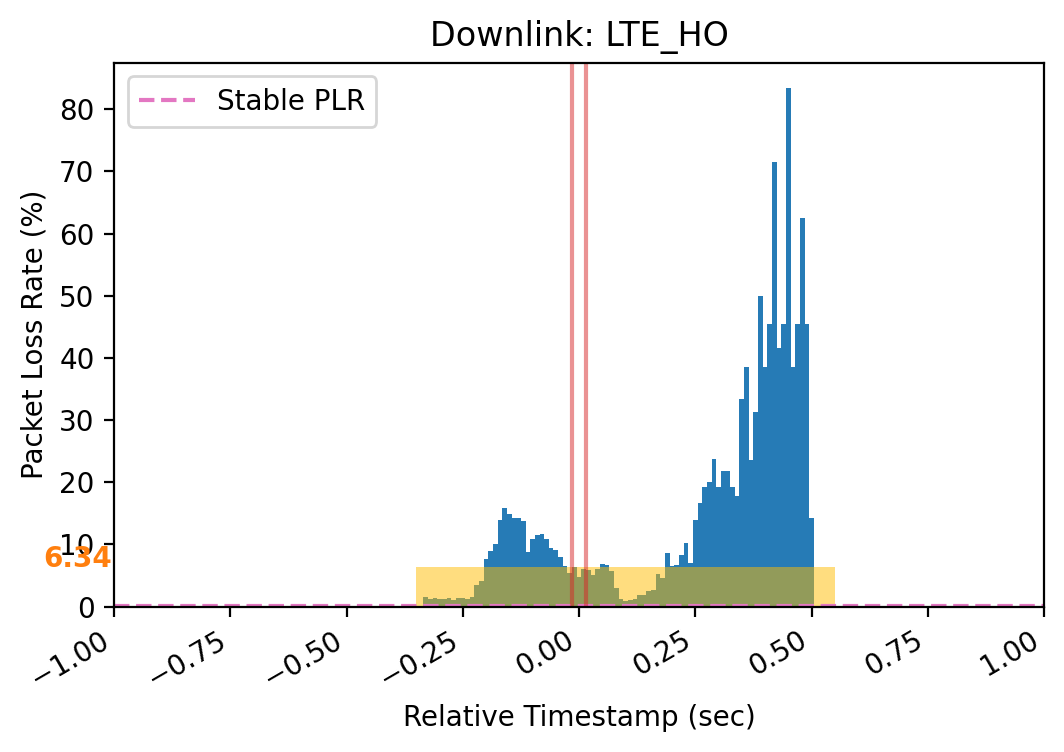

MN_HO
Avg Duration: 0.017619709652376615 seconds
HO Count: 892
Avg PLR: 1.2469546139428032 %


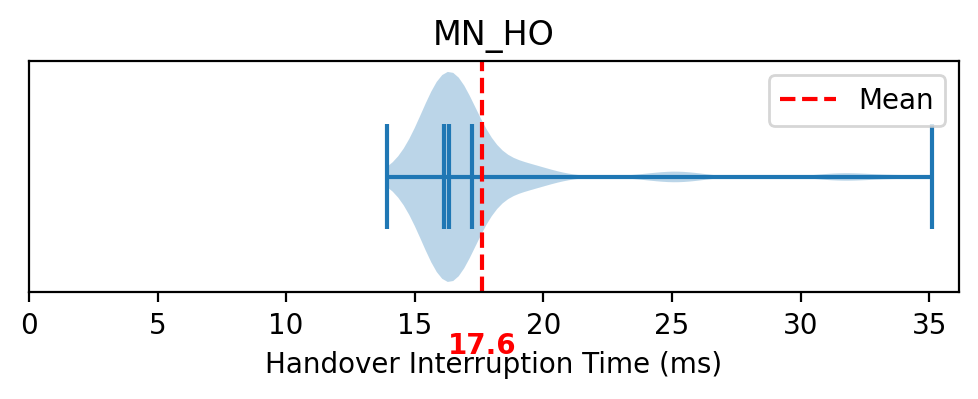

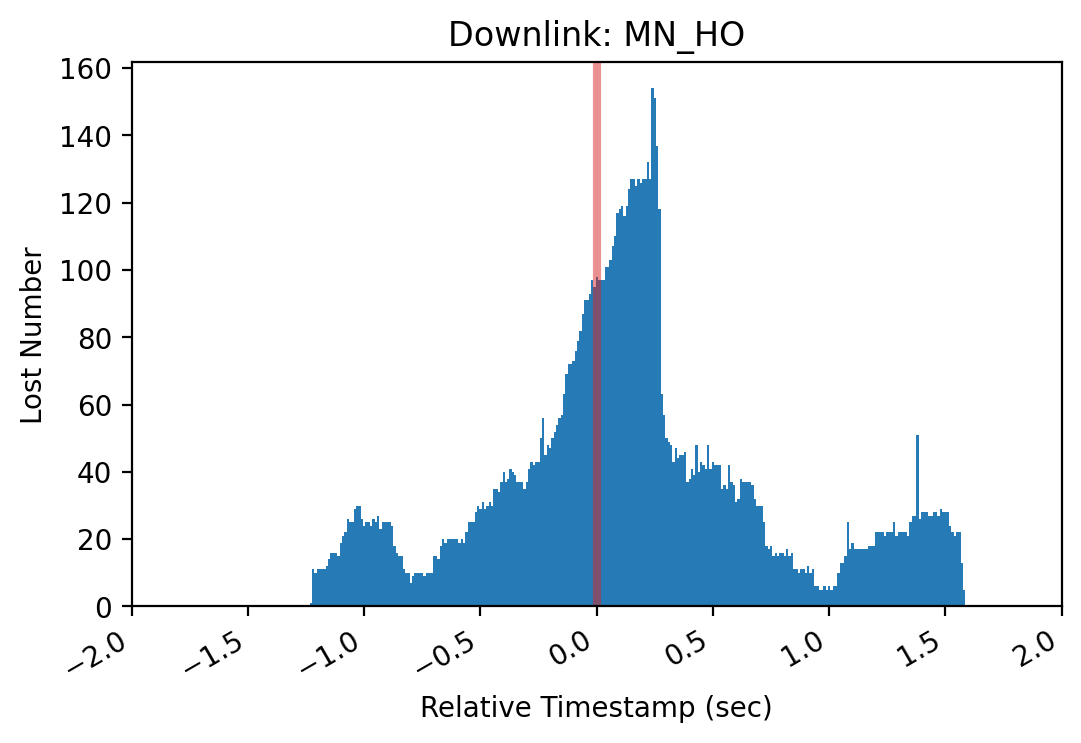

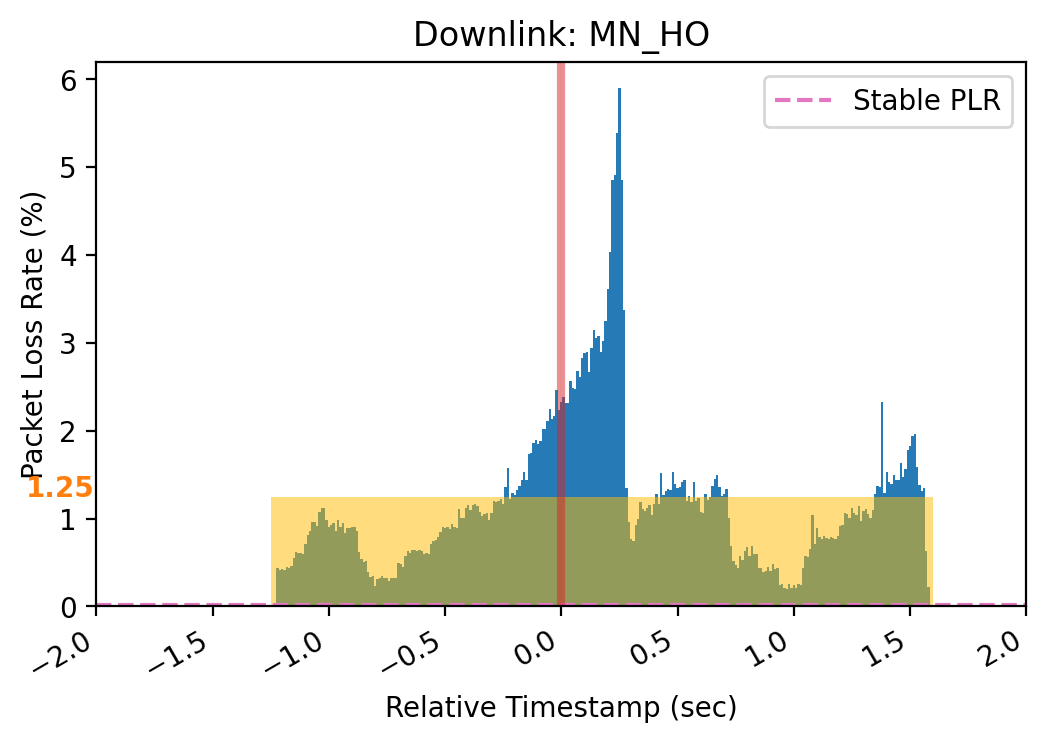

SN_HO
Avg Duration: 0.014639332258856446 seconds
HO Count: 951
Avg PLR: 0.5123886713947743 %


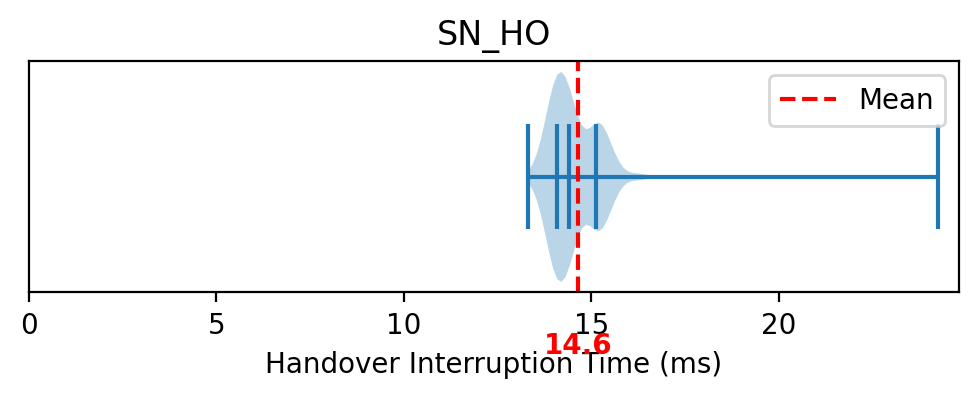

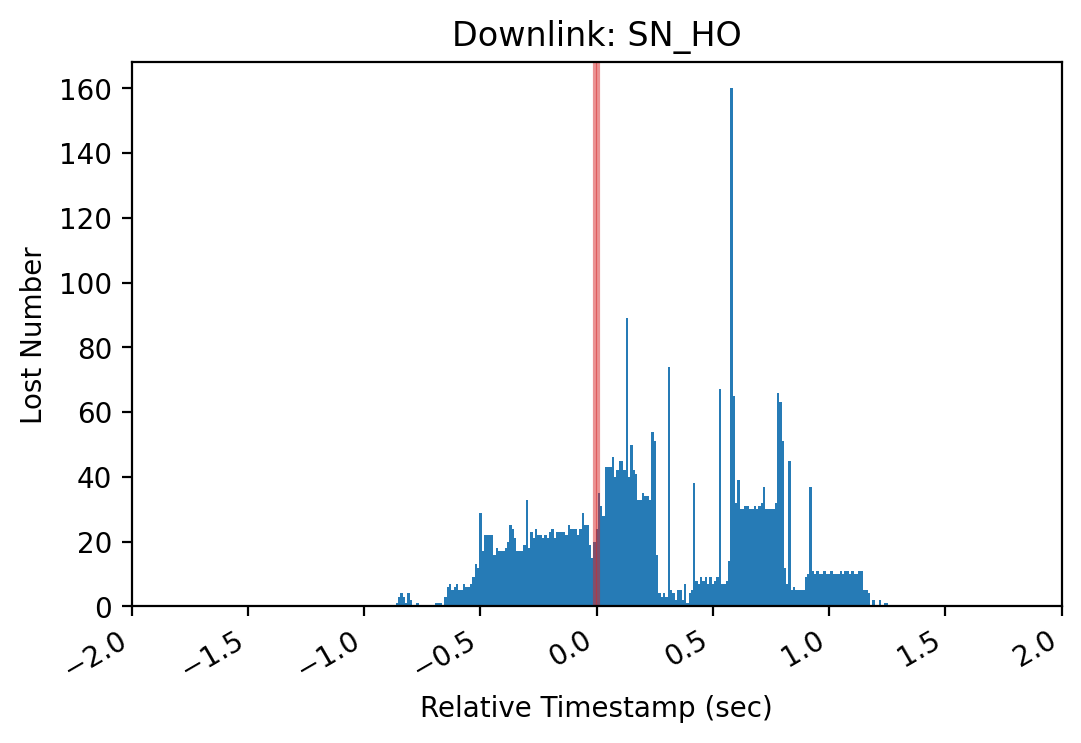

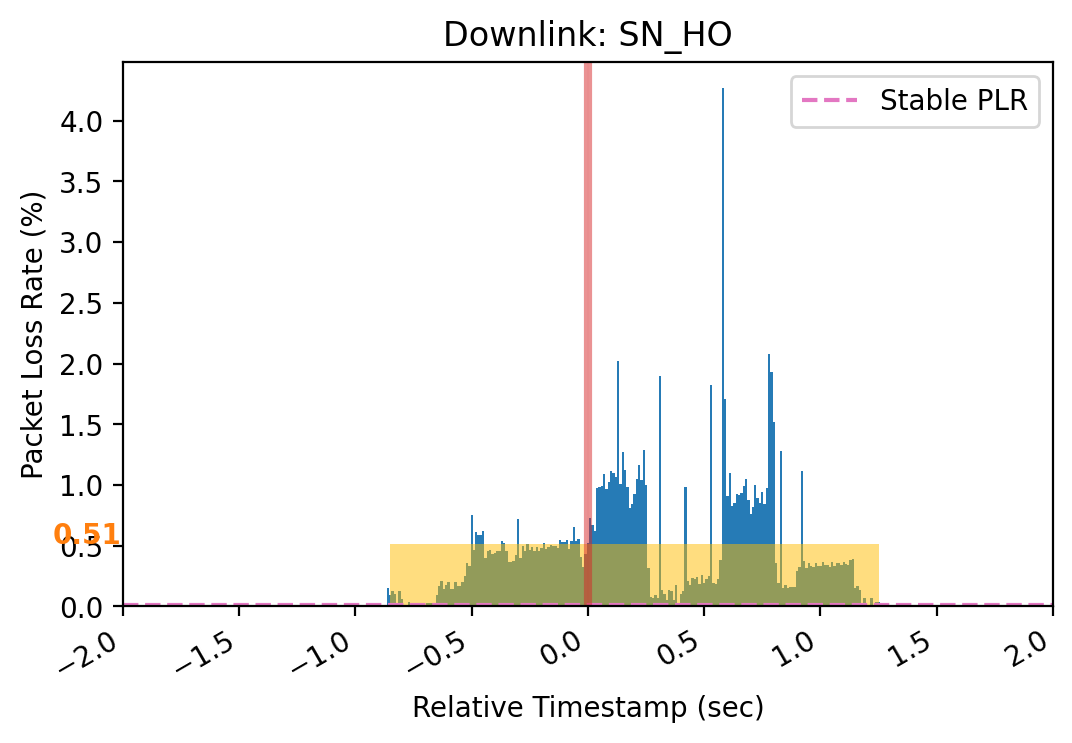

SN_Rel
Avg Duration: 0.02582324983086437 seconds
HO Count: 8
Avg PLR: 10.865874363309226 %


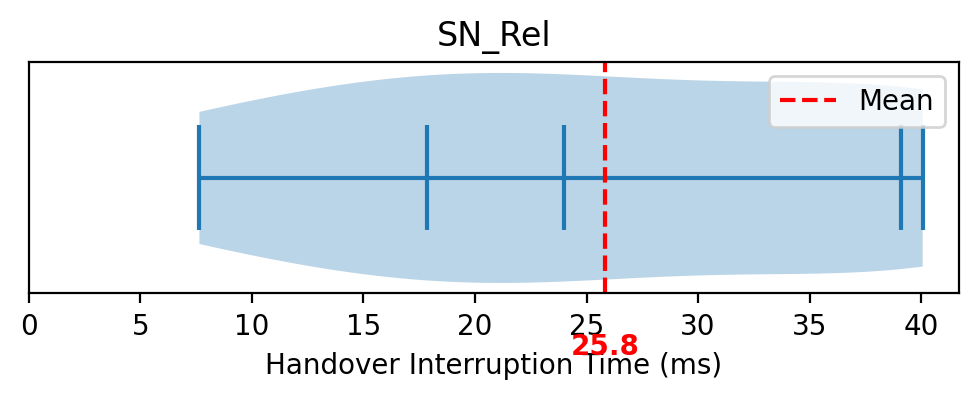

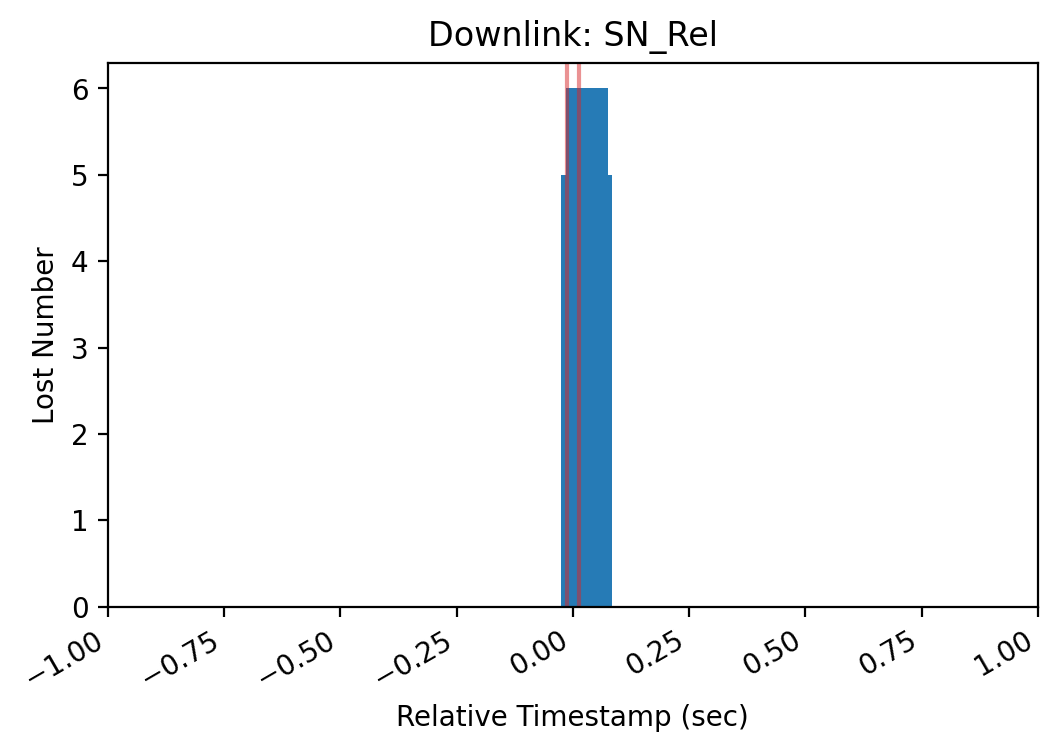

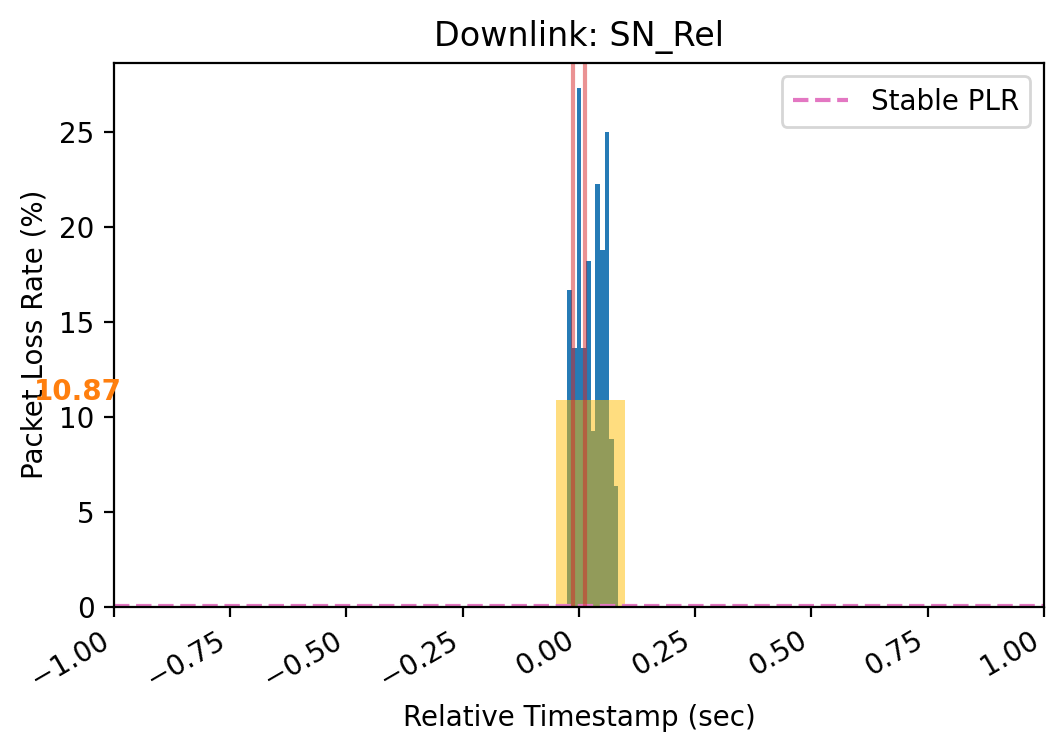

SN_Setup
Avg Duration: 0.028352583995276764 seconds
HO Count: 238
Avg PLR: 16.447994957418853 %


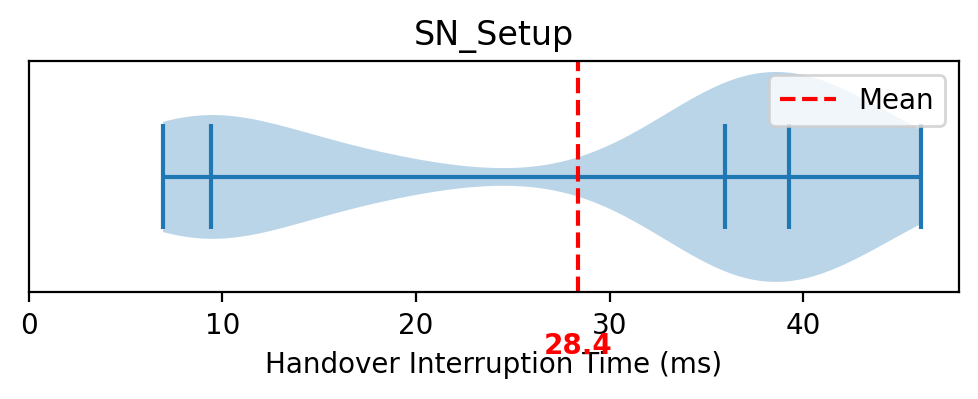

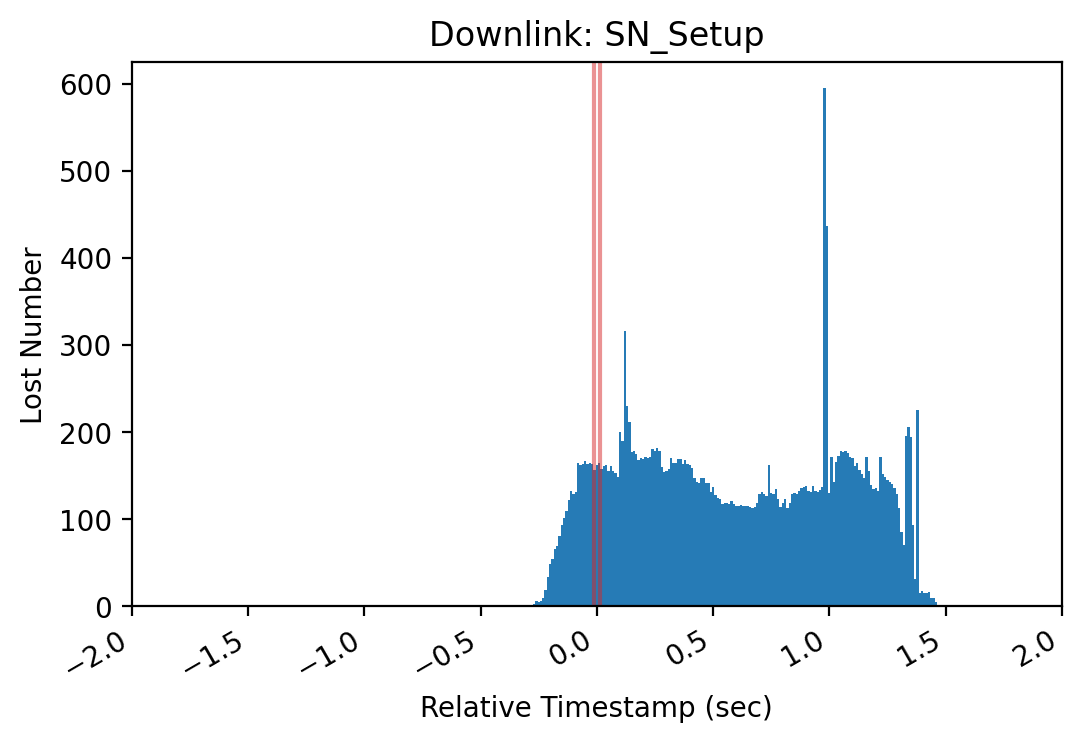

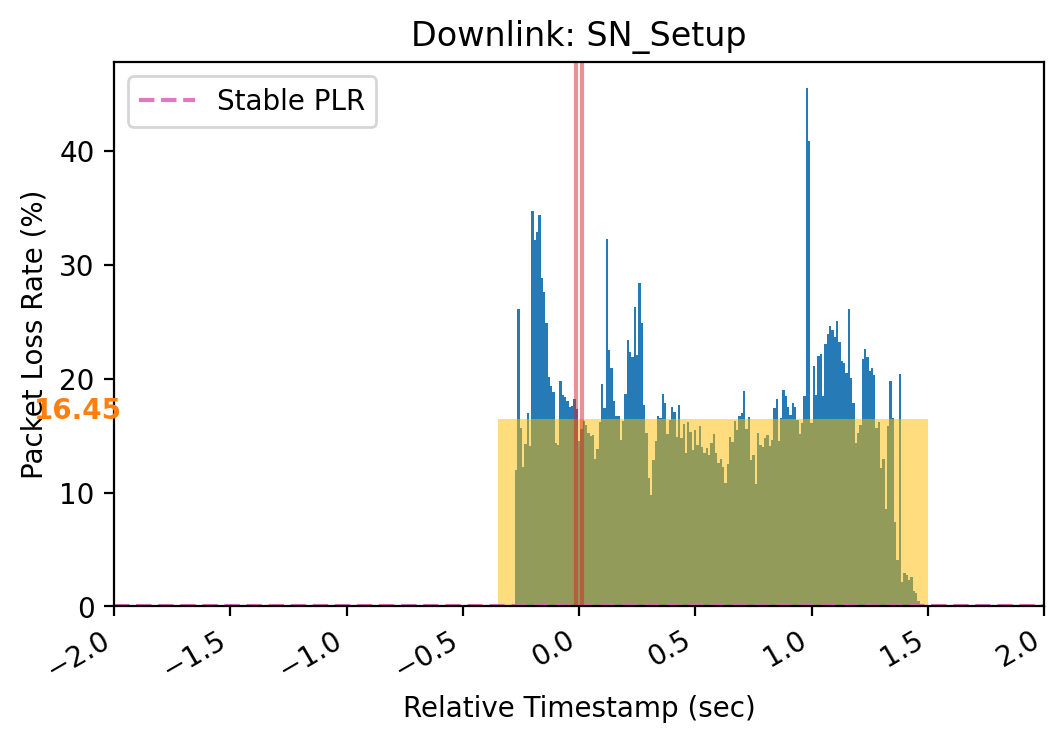

SN_Rel_MN_HO
Avg Duration: 0.016626903694914524 seconds
HO Count: 353
Avg PLR: 0.36462238838325733 %


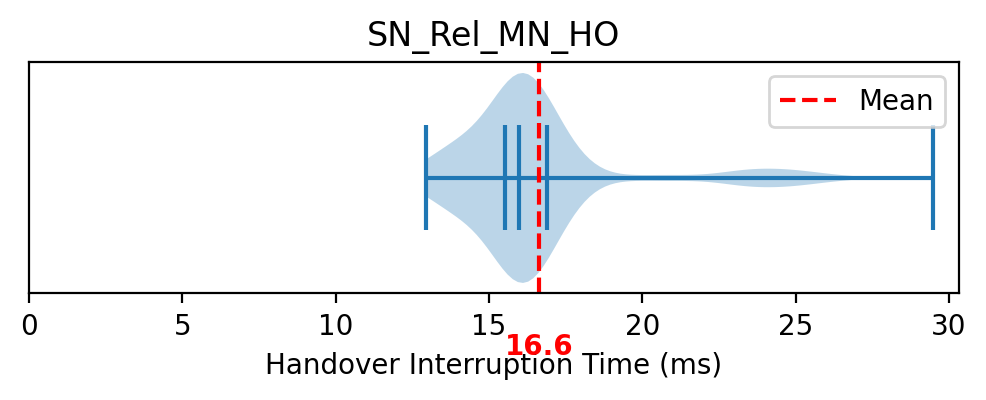

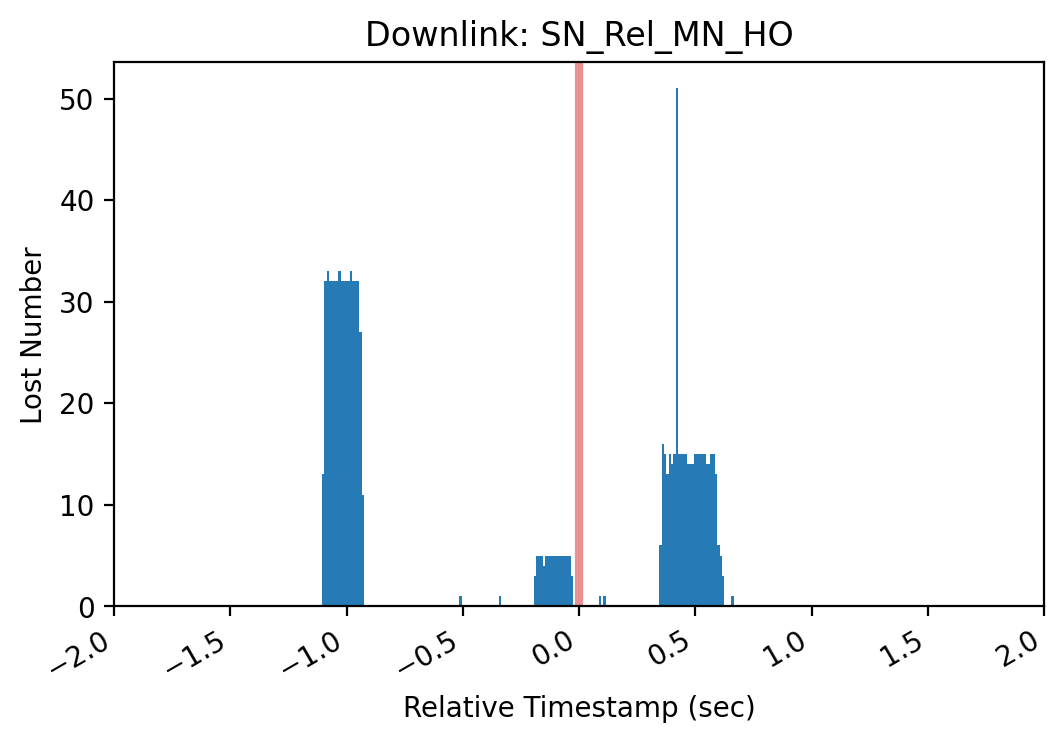

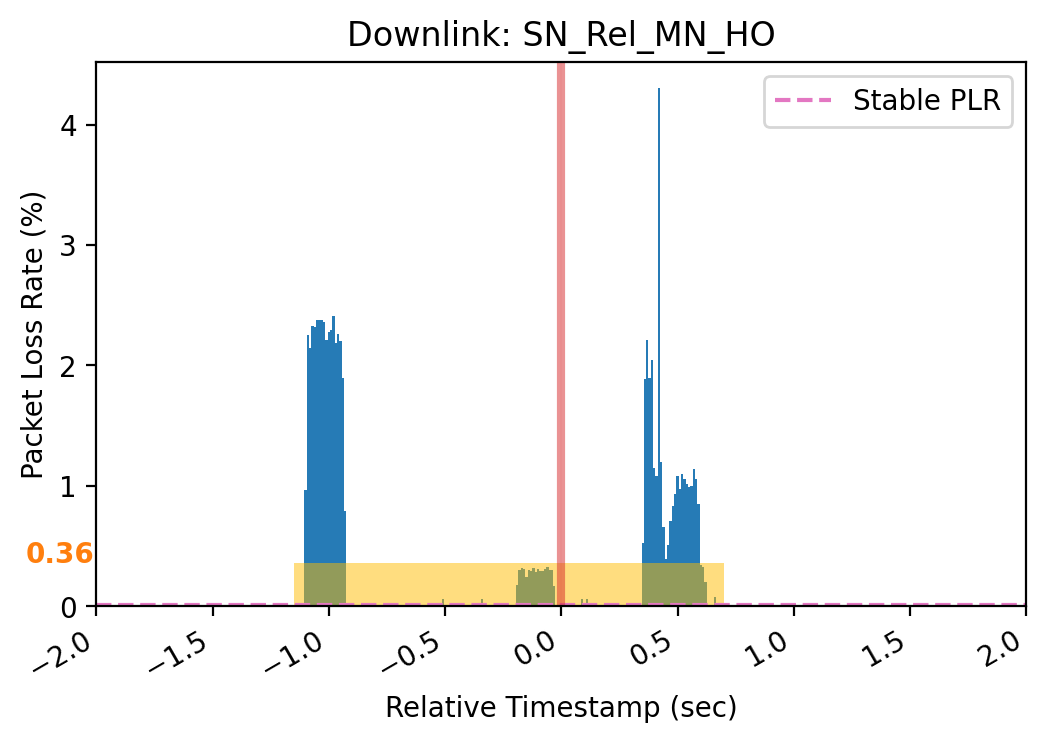

SCG_Failure_t310-Expiry (0)
Avg Duration: 0.0 seconds
HO Count: 3
Avg PLR: 61.629153269002636 %


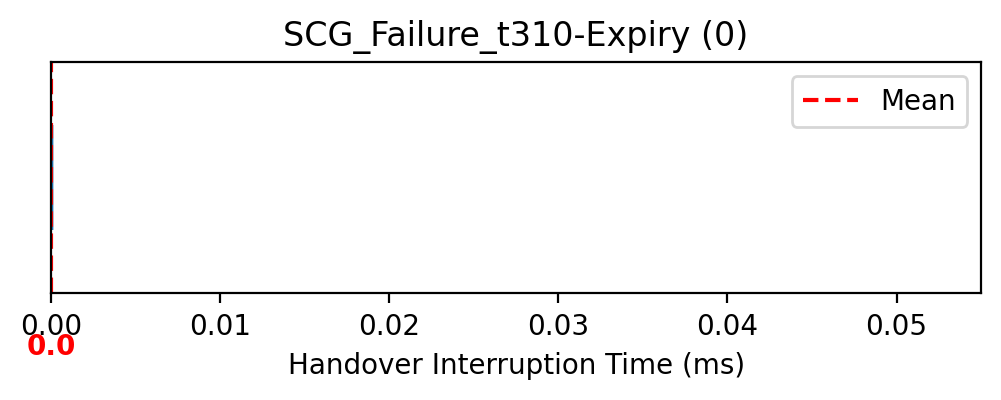

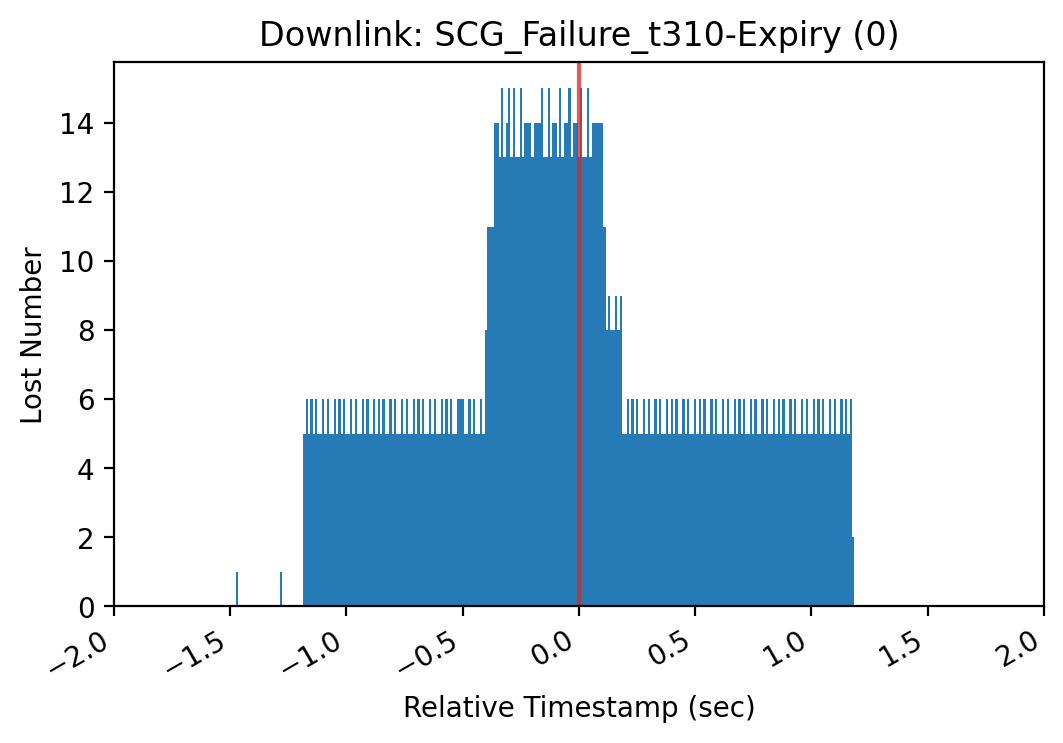

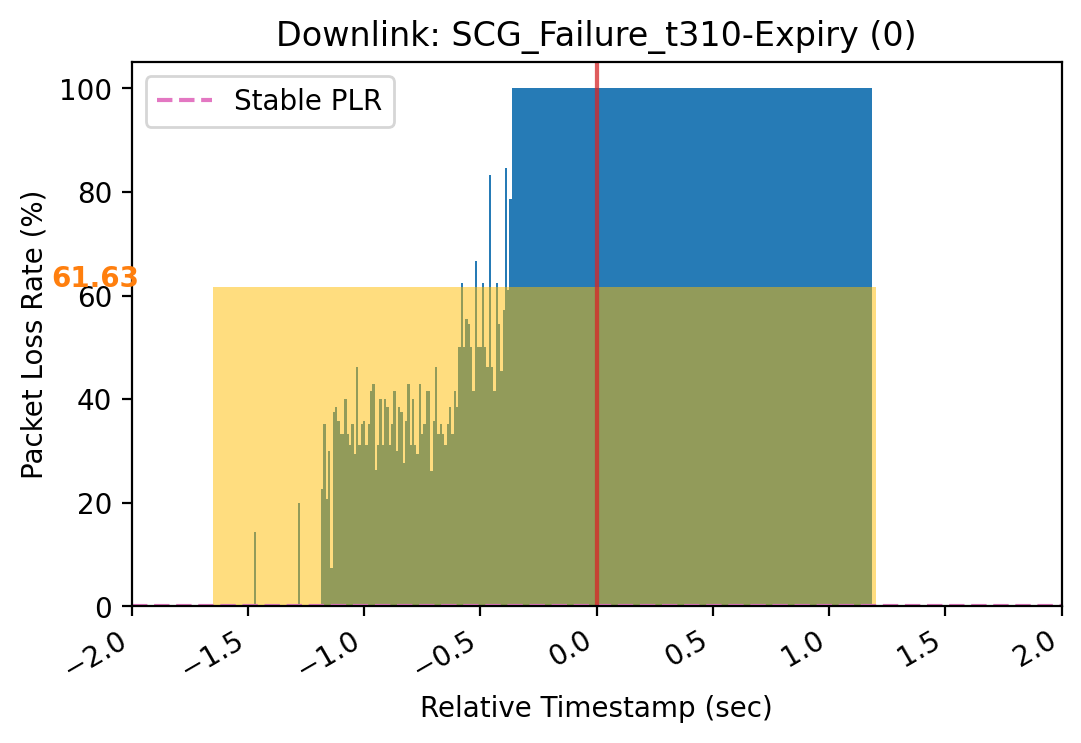

SCG_Failure_synchReconfigFailureSCG (3)
Avg Duration: 0.0 seconds
HO Count: 5
Avg PLR: 9.223300970829014 %


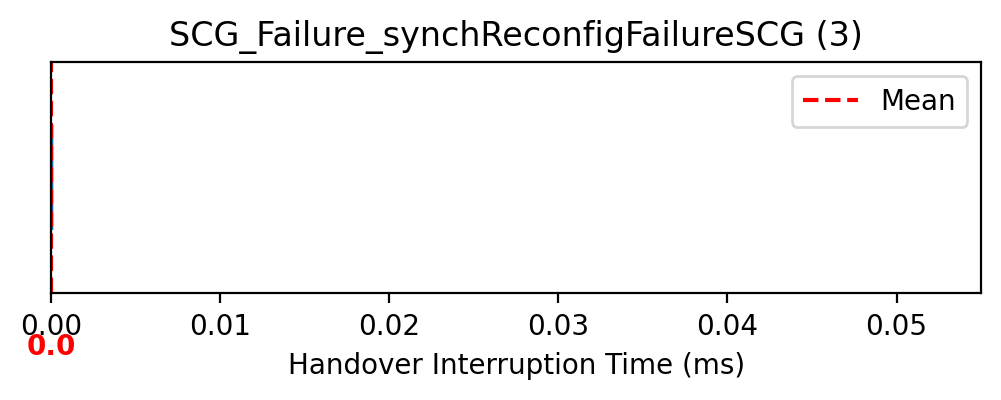

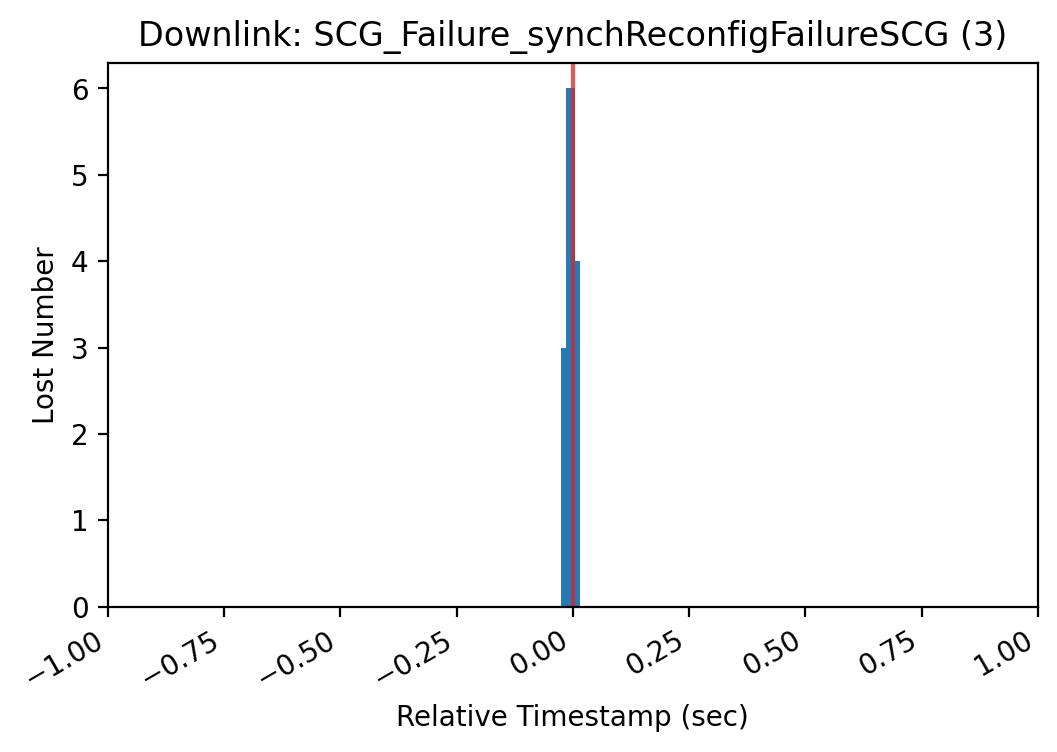

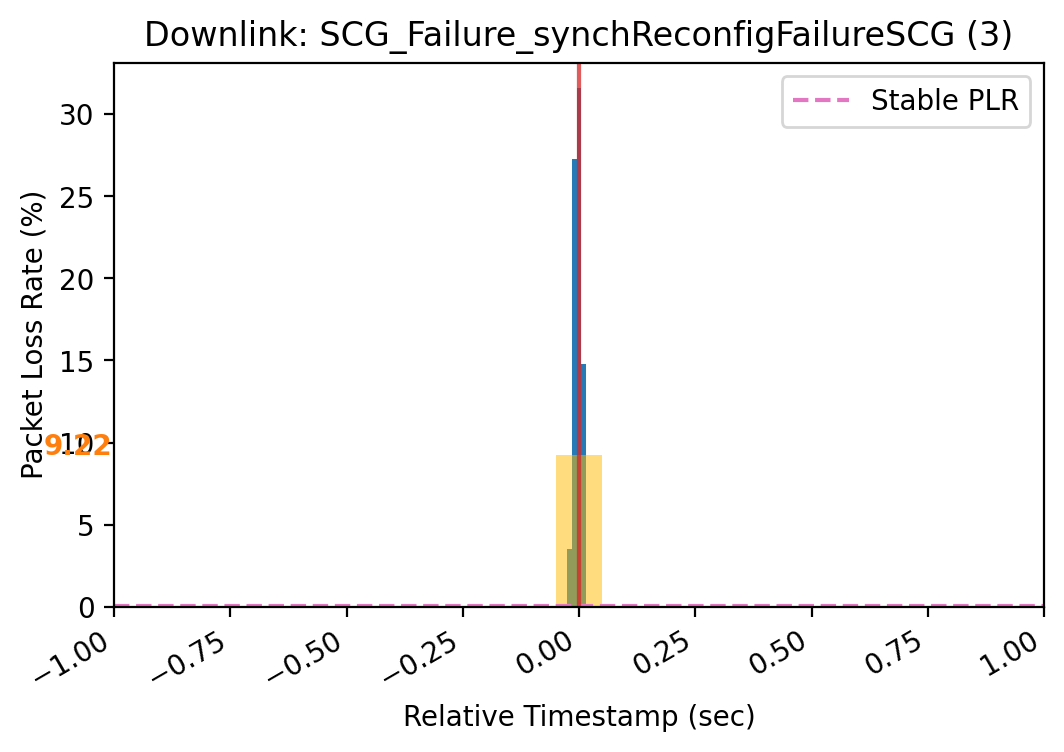

MCG_Failure_handoverFailure (1)
Avg Duration: 0.0812133003026247 seconds
HO Count: 10
Avg PLR: 56.44471594379101 %


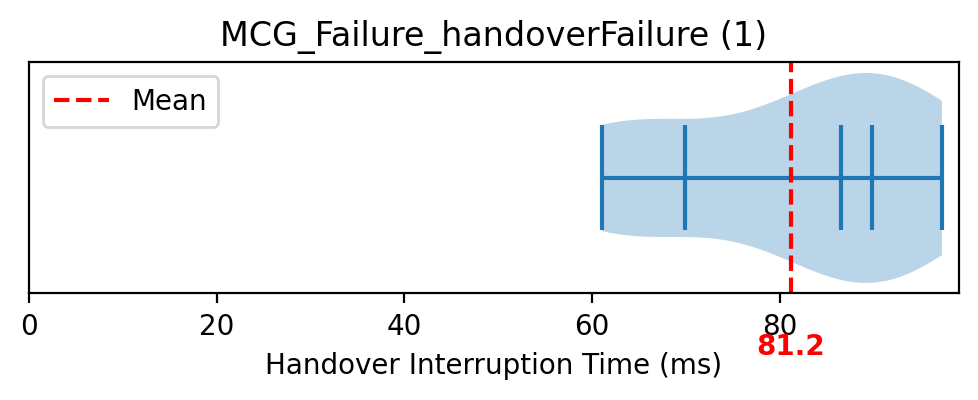

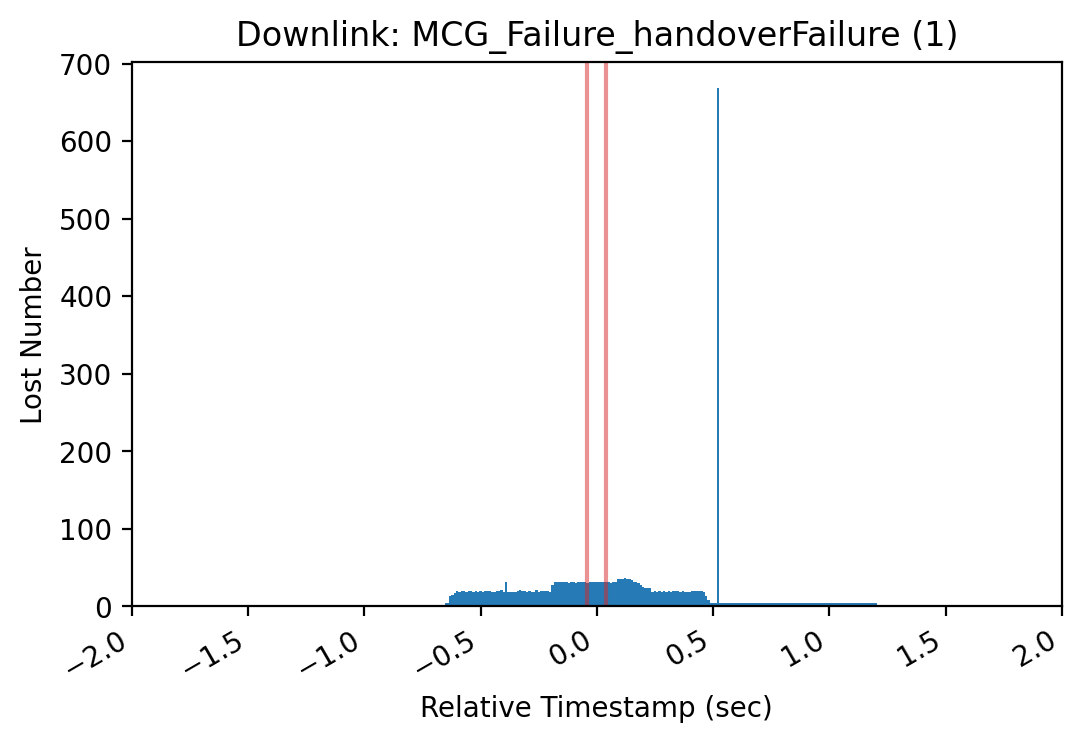

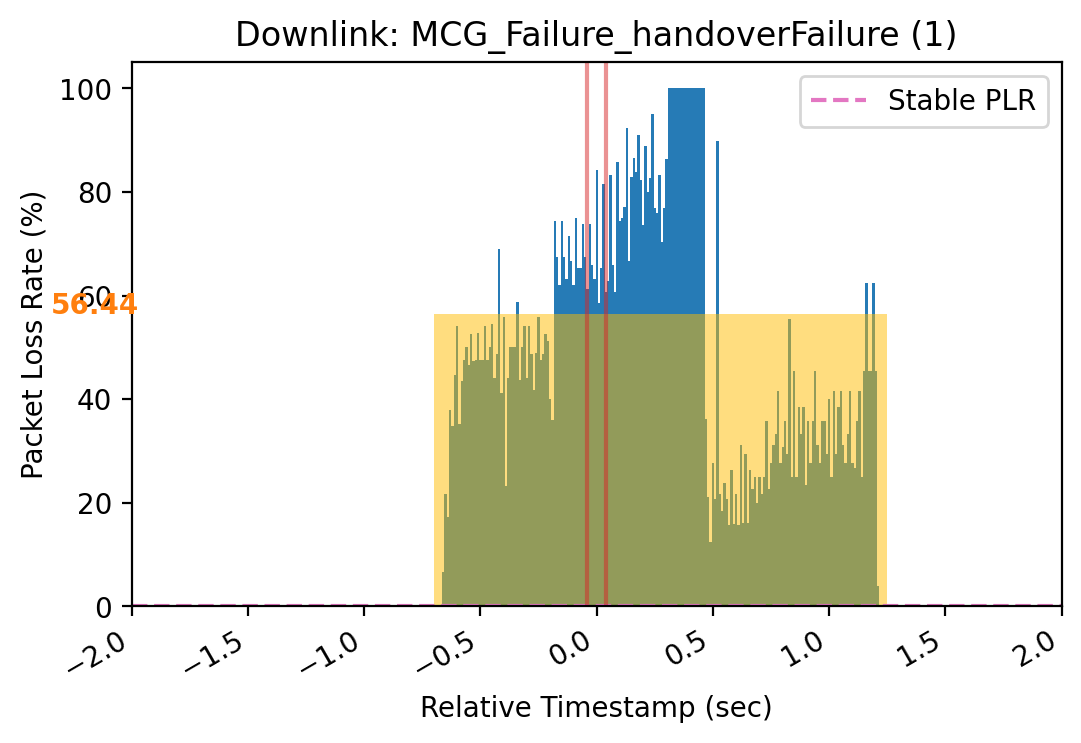

MCG_Failure_otherFailure (2)
Avg Duration: 0.07702575729350851 seconds
HO Count: 99
Avg PLR: 19.549831662020605 %


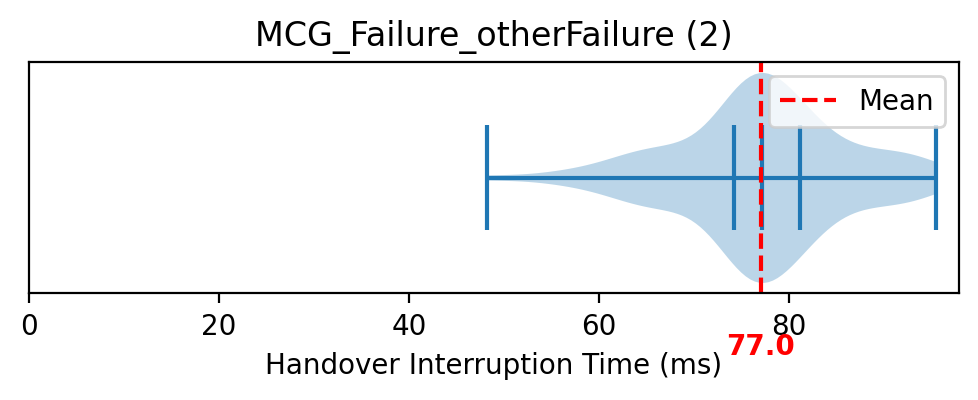

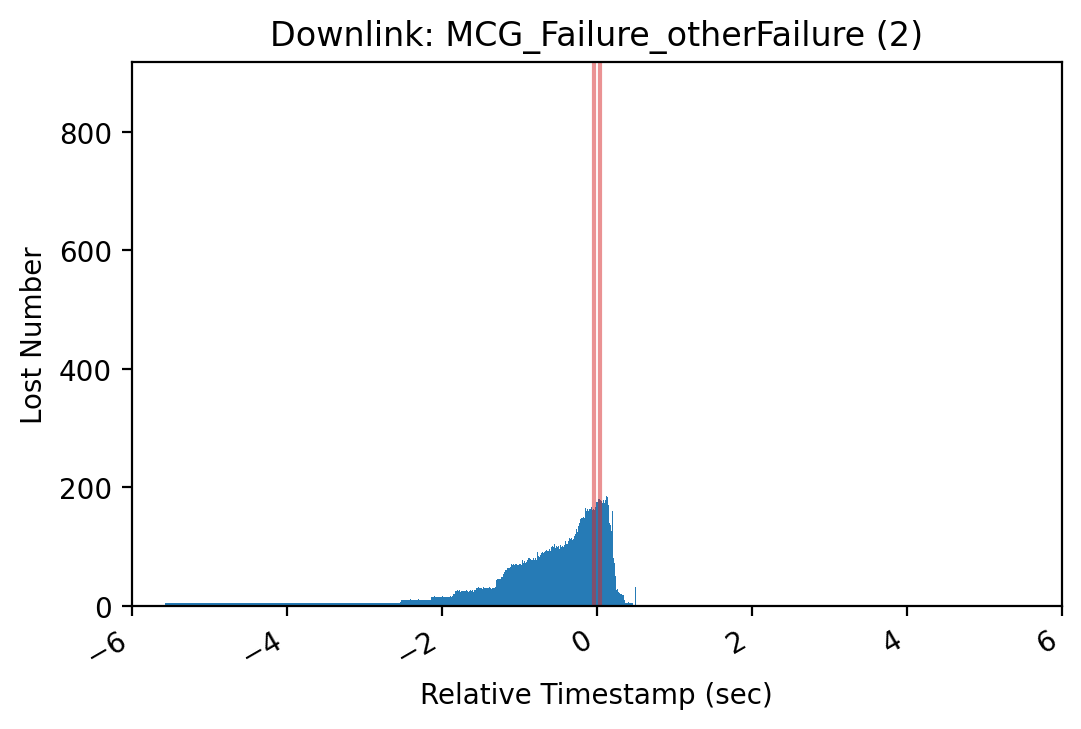

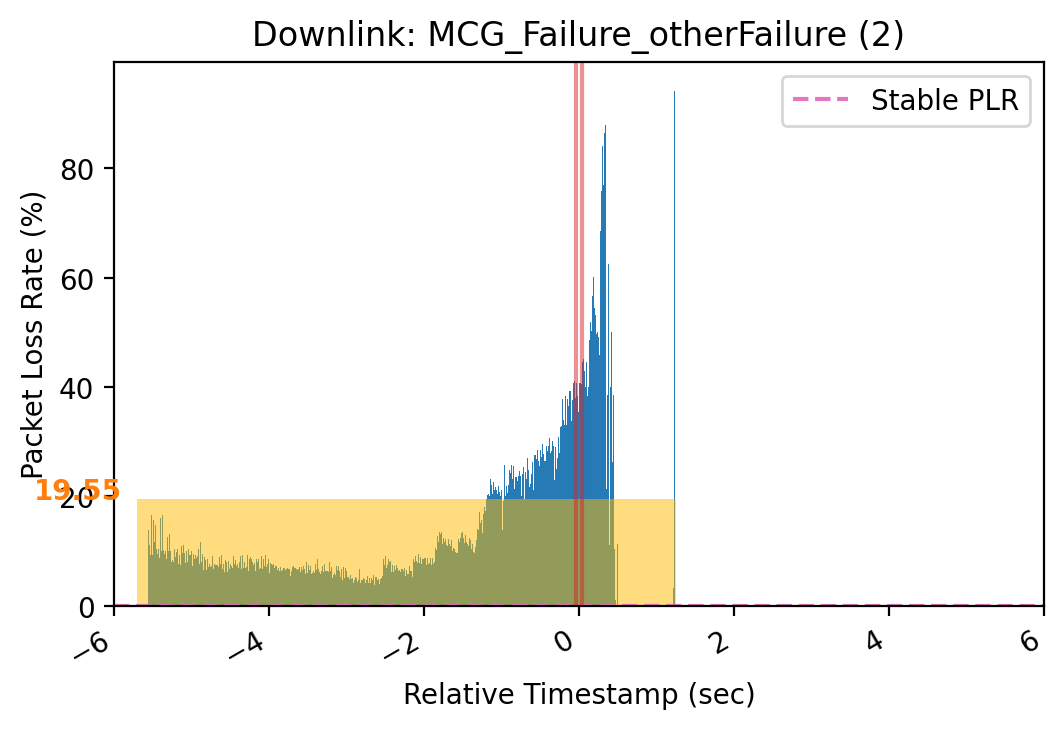

NAS_Recovery_otherFailure (2)
Avg Duration: 0.4677276611328125 seconds
HO Count: 3
Avg PLR: 70.60653188177659 %


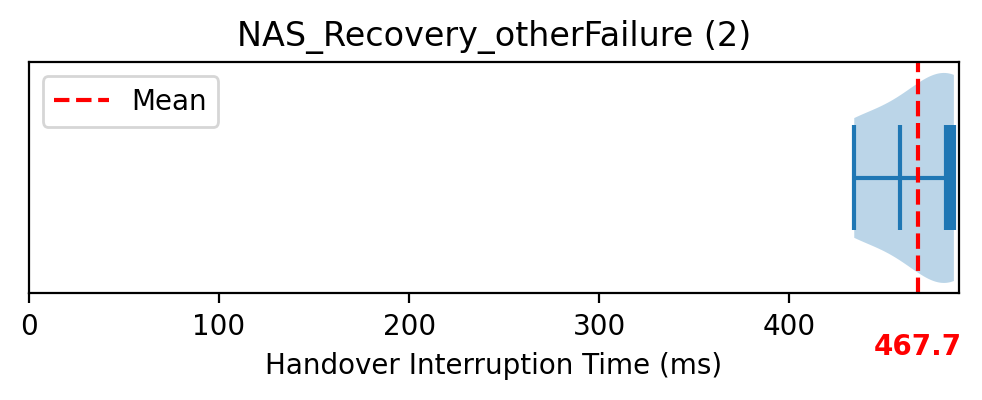

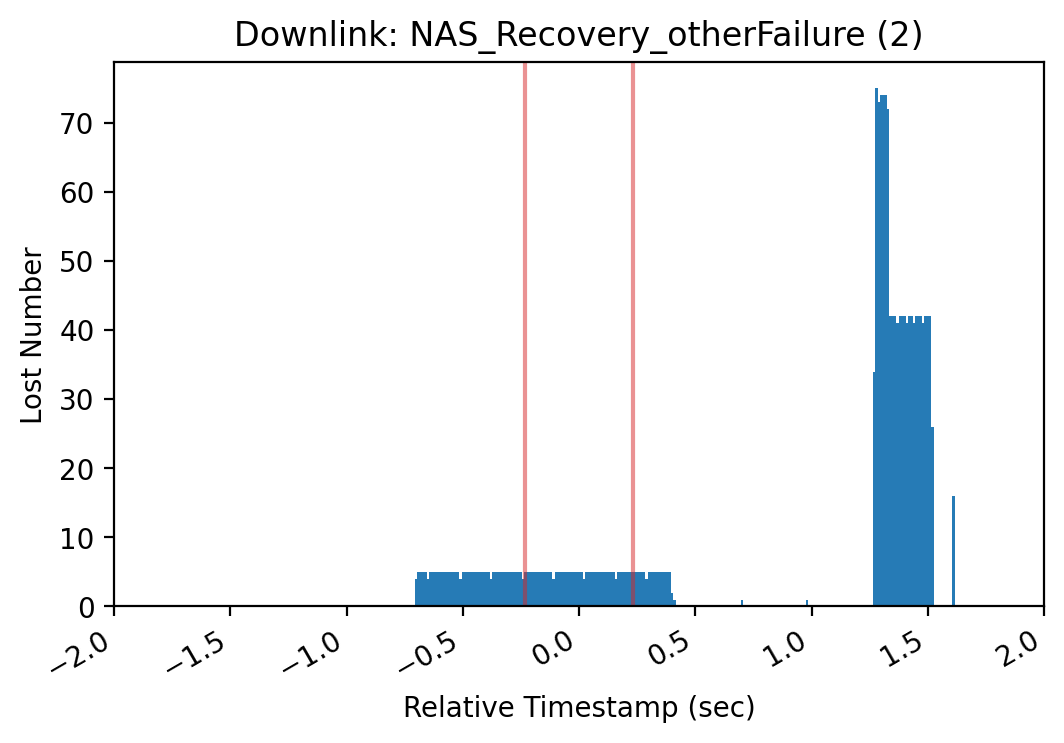

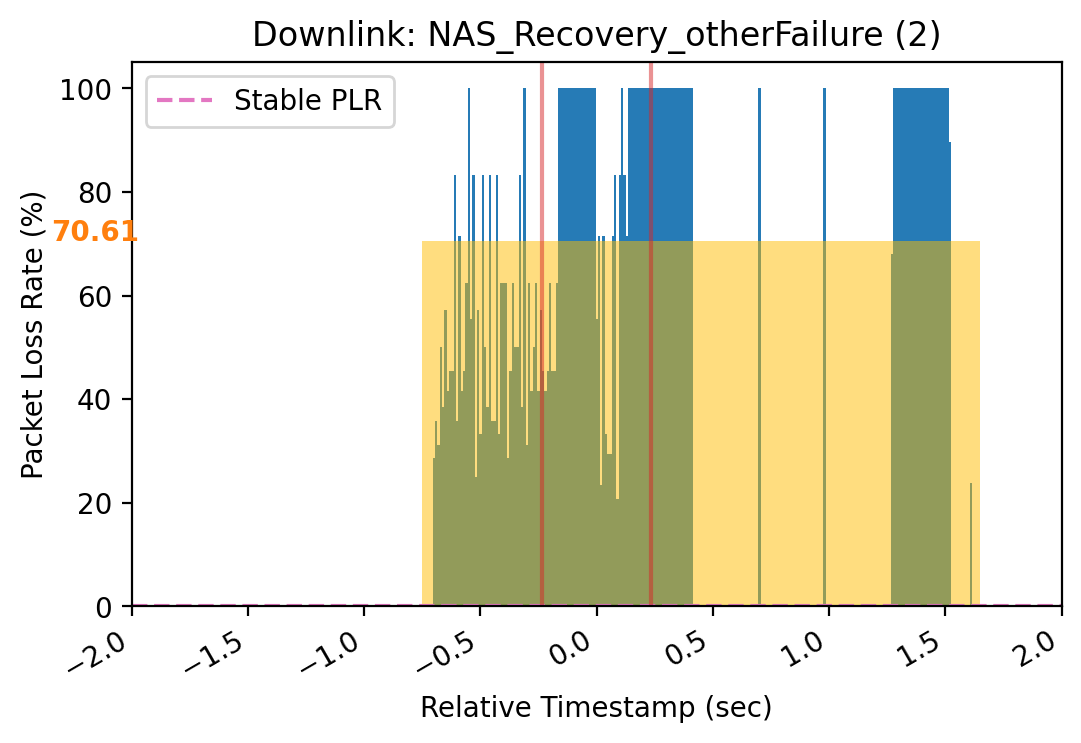

In [24]:
for tag in sorter:
    if len(D[tag]['intrs']) == 0:
        continue
    print('===================================')
    print(tag)
    table, intr = merge_profile(D[tag]['tables'], D[tag]['intrs'])
    print('Avg Duration:', intr, 'seconds')
    print('HO Count:', sum(D[tag]['count']))
    # display(table)
    # _table = table.query('PLR > @stable_plr').copy().reset_index(drop=True)
    _table = table.copy().reset_index(drop=True)
    tcount = sum(_table['tx_count'])
    lcount = sum(_table['lost'])
    plr = lcount / (tcount + 1e-9) * 100
    print('Avg PLR:', plr, '%')
    path = '/Users/jackbedford/Desktop/MOXA/2023-04-20/figure/'
    plot_intrs(D[tag]['intrs'], tag, path=path)
    wsize = math.ceil(max(ImpactScope[tag]))
    plot_profile(table, intr=intr, title=tag, mode='lost', xlim=wsize, path=path, flow='dl')
    plot_profile(table, intr=intr, title=tag, mode='plr', xlim=wsize, path=path, flow='dl', stable_plr=stable_plr, plr=plr)

## Uplink

### Transmission Time

In [25]:
sorter = ['LTE_HO','MN_HO','SN_HO','MNSN_HO','SN_Rel','SN_Setup','SN_Rel_MN_HO','SN_Setup_MN_HO',
          'SCG_Failure_t310-Expiry (0)','SCG_Failure_randomAccessProblem (1)','SCG_Failure_rlc-MaxNumRetx (2)','SCG_Failure_synchReconfigFailureSCG (3)',
          'SCG_Failure_scg-ReconfigFailure (4)','SCG_Failure_srb3-IntegrityFailure (5)','SCG_Failure_other-r16 (6)',
          'MCG_Failure_reconfigurationFailure (0)','MCG_Failure_handoverFailure (1)','MCG_Failure_otherFailure (2)',
          'NAS_Recovery_reconfigurationFailure (0)','NAS_Recovery_handoverFailure (1)','NAS_Recovery_otherFailure (2)']

D = {}
for tag in sorter:
    D[tag] = {'tables': [], 'intrs': [], 'count': []}
stable_pkt = 0
stable_loss = 0
for (exp, traces), devices, schemes in zip(exps.items(), _devices, _schemes):
    for trace in traces:
        for j, (dev, schm) in enumerate(zip(devices, schemes)):
            ## read downlink
            data = os.path.join(datadir, exp, dev, trace, 'data', 'udp_dnlk_loss_latency.csv')
            print(data, os.path.isfile(data))
            df_ul = pd.read_csv(data)
            df_ul = set_data(df_ul)
            ## read handover
            path = os.path.join(datadir, exp, dev, trace, 'data')
            data = os.path.join(path, [s for s in os.listdir(path) if s.startswith('diag_log_') and s.endswith('_rrc.csv')][0])
            print(data, os.path.isfile(data))
            df_ho = pd.read_csv(data)
            df_ho, _, _ = mi_parse_ho(df_ho, tz=8)
            df_ho['ho_type0'] = df_ho['ho_type'].astype('string')
            df_ho.loc[df_ho['cause'].notna(), 'ho_type0'] = df_ho['ho_type'].astype('string') + '_' + df_ho['cause'].astype('string')
            df_ho['ho_type0'] = df_ho['ho_type0'].astype('category')
            ## start processing
            df = df_ho[~np.in1d(df_ho['ho_type'], ['Conn_Setup', 'Conn_Rel'])].copy().reset_index(drop=True)
            A = {}
            for tag in sorter:
                A[tag] = {'tables': [], 'intrs': []}
            _intv = P.singleton(pd.Timestamp.min)
            for i, row in df.iterrows():
                prior_row = df.iloc[i-1] if i != 0 else None
                post_row = df.iloc[i+1] if i != len(df)-1 else None
                ### peek the next event: avoid MN/LTE HO overlaps with handoverFailure
                if i != len(df)-1 and pd.notna(row.end) and row.end > post_row.start:
                    print(i, row.start, row.end, row.ho_type, row.cause)
                    print(i+1, post_row.start, post_row.end, post_row.ho_type, post_row.cause)
                    continue
                if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
                    prior_row = df.iloc[i-2] if i > 1 else None
                ### basic timestamp
                tag = row.ho_type0
                start, end = row.start, row.end
                intr = row.intr if pd.notna(row.intr) else 0
                ### set left, right limit
                if prior_row is not None:
                    if pd.notna(prior_row.end):
                        # left = prior_row.end
                        left = prior_row.end + (start - prior_row.end) / 2
                    else:
                        # left = prior_row.start
                        left = prior_row.start + (start - prior_row.start) / 2
                else:
                    left = pd.Timestamp.min
                if post_row is not None:
                    if pd.notna(end):
                        # right = post_row.start
                        right = end + (post_row.start - end) / 2
                    else:
                        # right = post_row.start
                        right = start + (post_row.start - start) / 2
                else:
                    right = pd.Timestamp.max
                ### 
                table, intv = setup_profile(df_ul, tag, start, end, mode='ul', sec=wsize, left=left, right=right)
                # print(intr)
                # display(table)
                A[tag]['tables'].append(table)
                A[tag]['intrs'].append(intr)
            ### count stable loss, pkt
                if i == 0:
                    lower = pd.Timestamp.min
                    upper = intv.lower
                else:
                    lower = _intv.upper
                    upper = intv.lower
                df_tmp = df_ul.query('xmit_time > @lower & xmit_time <= @upper').copy().reset_index(drop=True)
                stable_pkt += len(df_tmp)
                stable_loss += sum(df_tmp['lost'])
                _intv = intv
            lower = _intv.upper
            upper = pd.Timestamp.max
            df_tmp = df_ul.query('xmit_time > @lower & xmit_time <= @upper').copy().reset_index(drop=True)
            stable_pkt += len(df_tmp)
            stable_loss += sum(df_tmp['lost'])
            for tag in sorter:
                if len(A[tag]['tables']) == 0:
                    continue
                table, intr = merge_profile(A[tag]['tables'], A[tag]['intrs'])
                # print('HO Count:', len(df))
                D[tag]['tables'].append(table)
                D[tag]['intrs'] = [*D[tag]['intrs'], *A[tag]['intrs']]
                D[tag]['count'].append(len(A[tag]['tables']))
            stable_plr = stable_loss / (stable_pkt + 1e-9) * 100
            print(stable_loss, stable_pkt, round(stable_plr, 3))

/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#01/data/udp_dnlk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#01/data/diag_log_qc00_2023-03-16_19-23-29_rrc.csv True
0 119064 0.0
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc02/#01/data/udp_dnlk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc02/#01/data/diag_log_qc02_2023-03-16_19-23-29_rrc.csv True
0 221381 0.0
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc03/#01/data/udp_dnlk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc03/#01/data/diag_log_qc03_2023-03-16_19-23-29_rrc.csv True
0 318306 0.0
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#02/data/udp_dnlk_loss_latency.csv T

LTE_HO
Avg Duration: 0.03025620725971681 seconds
HO Count: 135
Avg PLR: 6.228288855286026 %


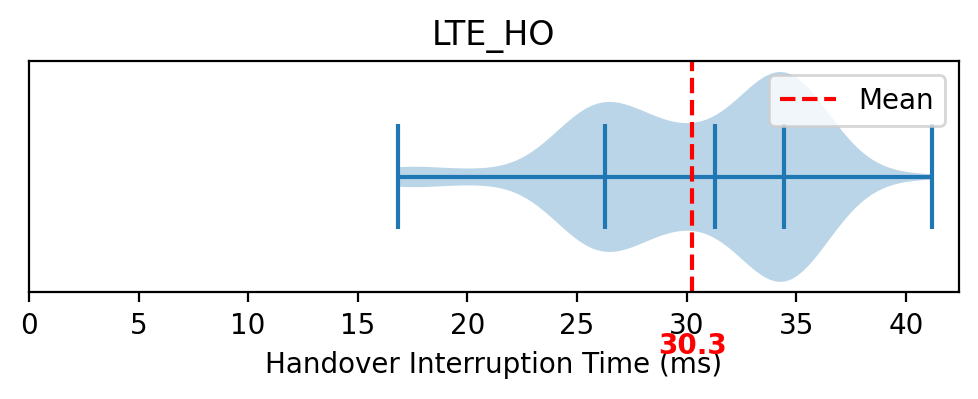

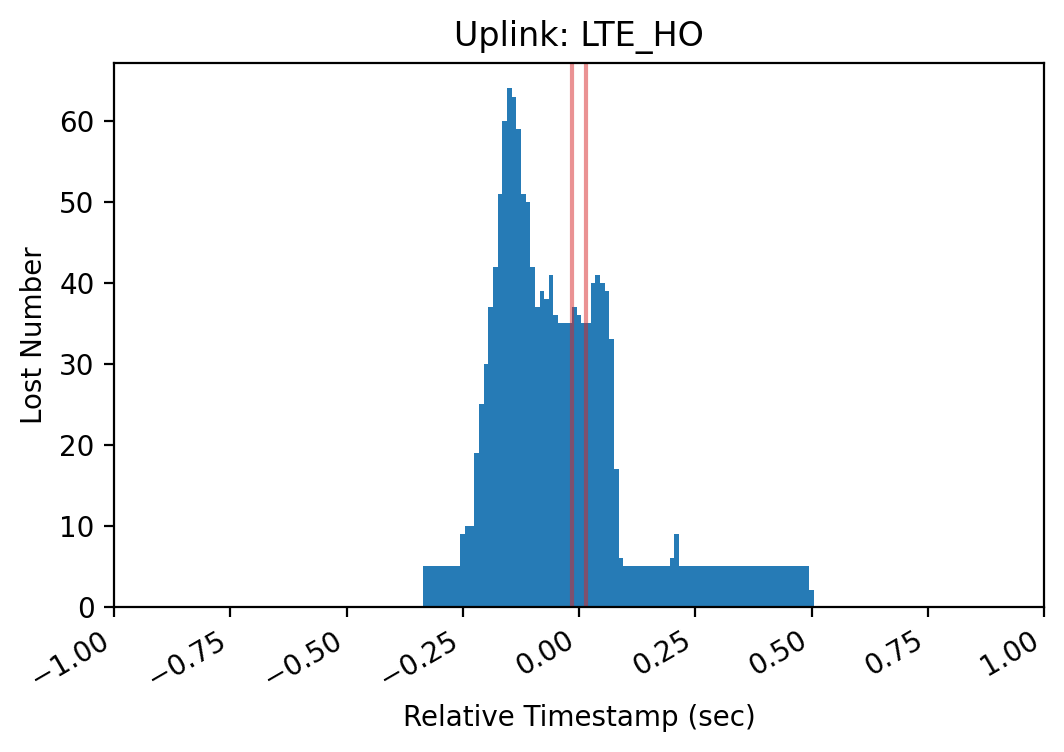

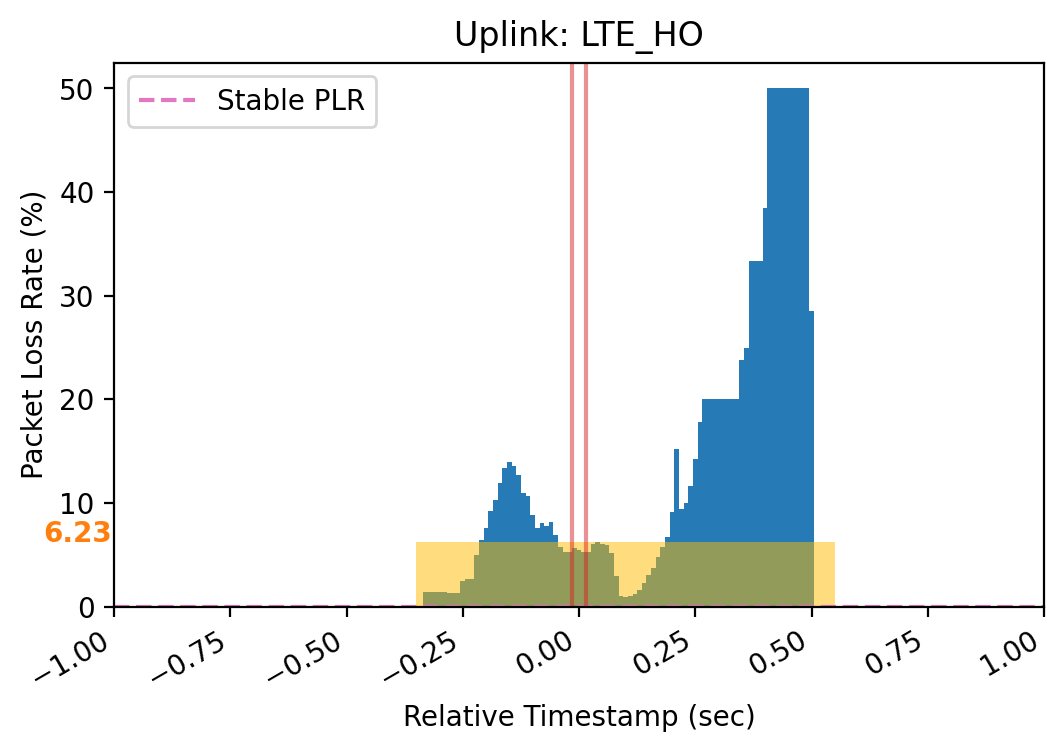

MN_HO
Avg Duration: 0.017619709652376615 seconds
HO Count: 892
Avg PLR: 1.1993637478282673 %


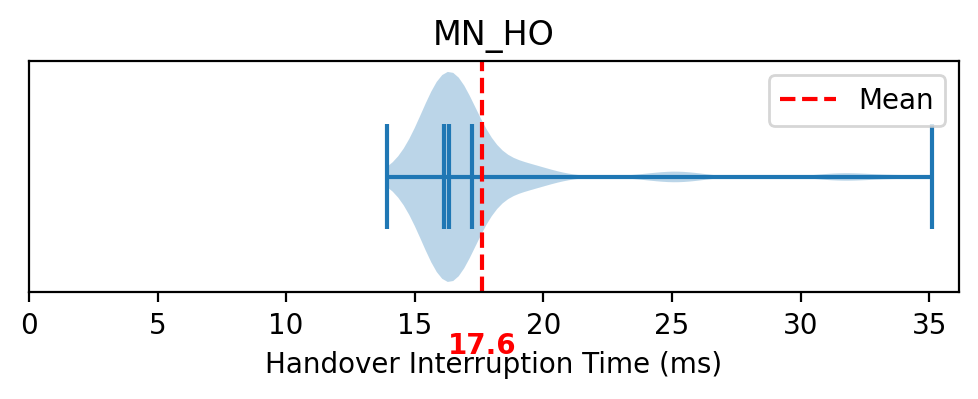

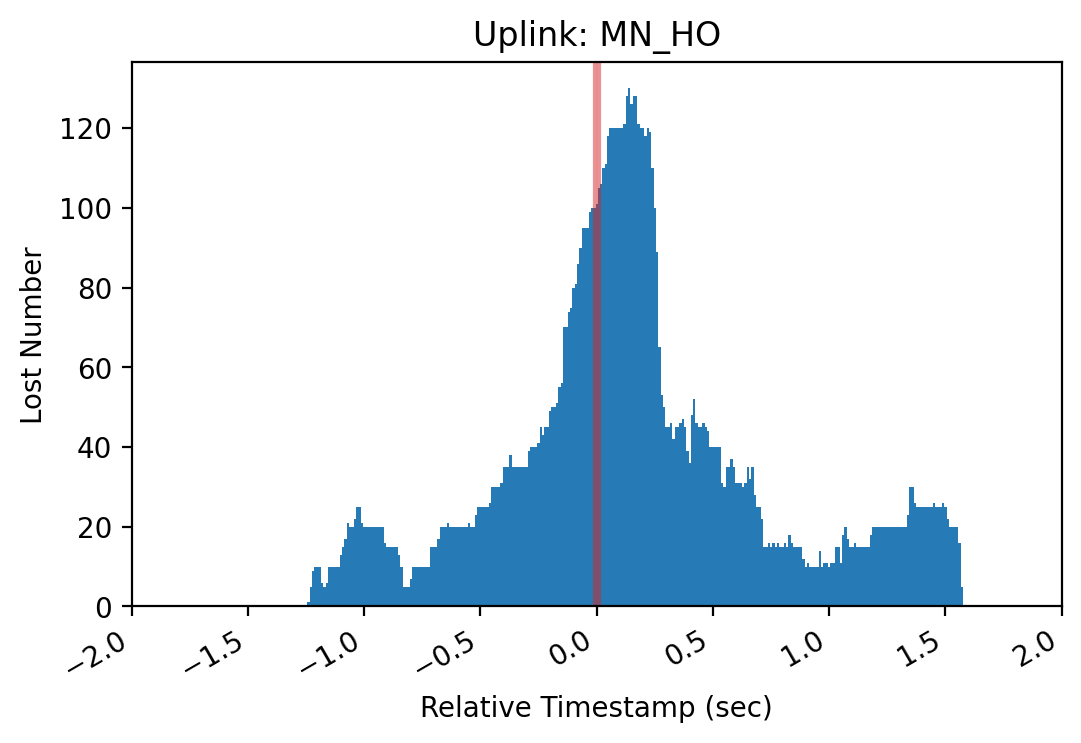

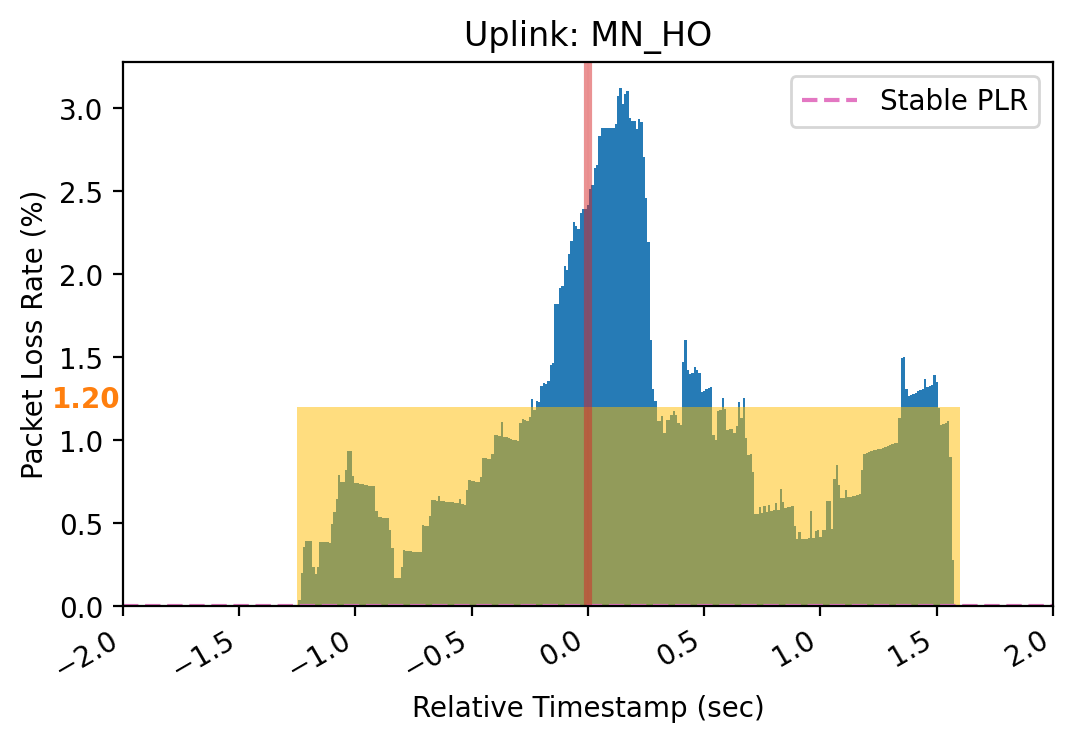

SN_HO
Avg Duration: 0.014639332258856446 seconds
HO Count: 951
Avg PLR: 0.5380088569414996 %


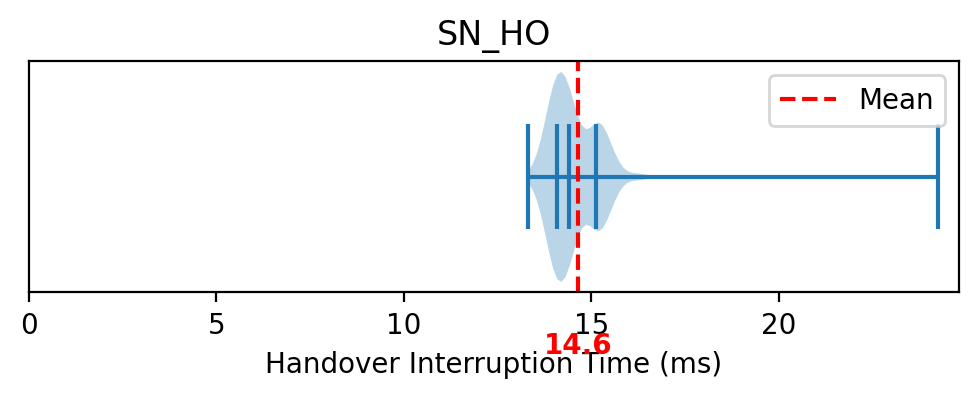

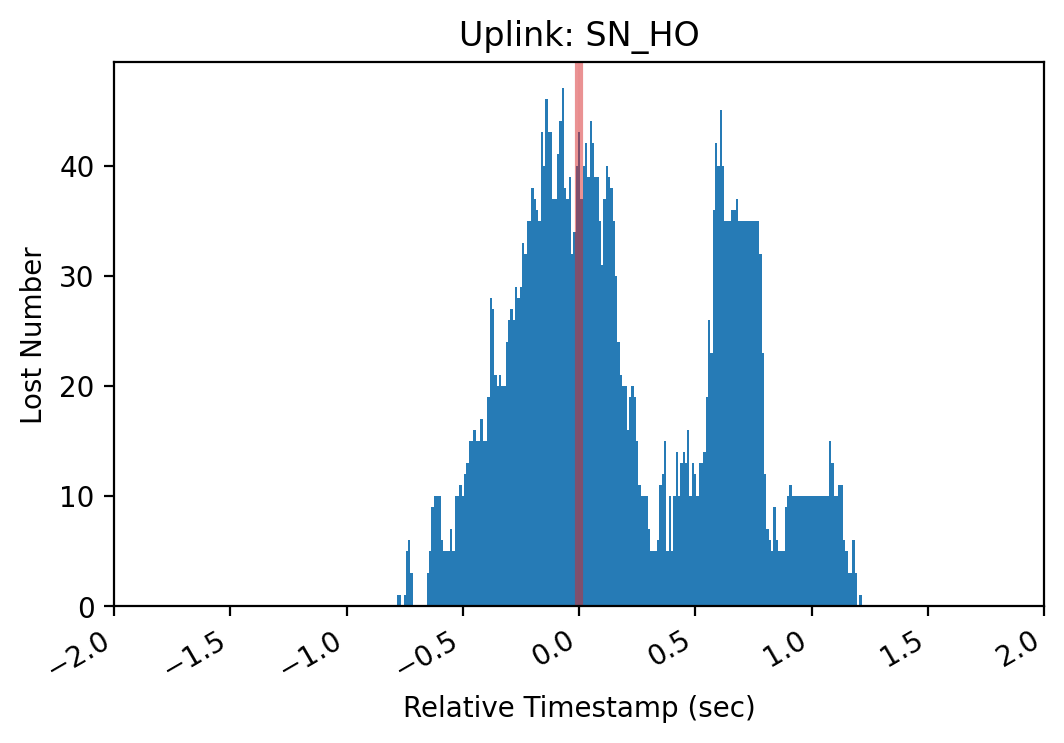

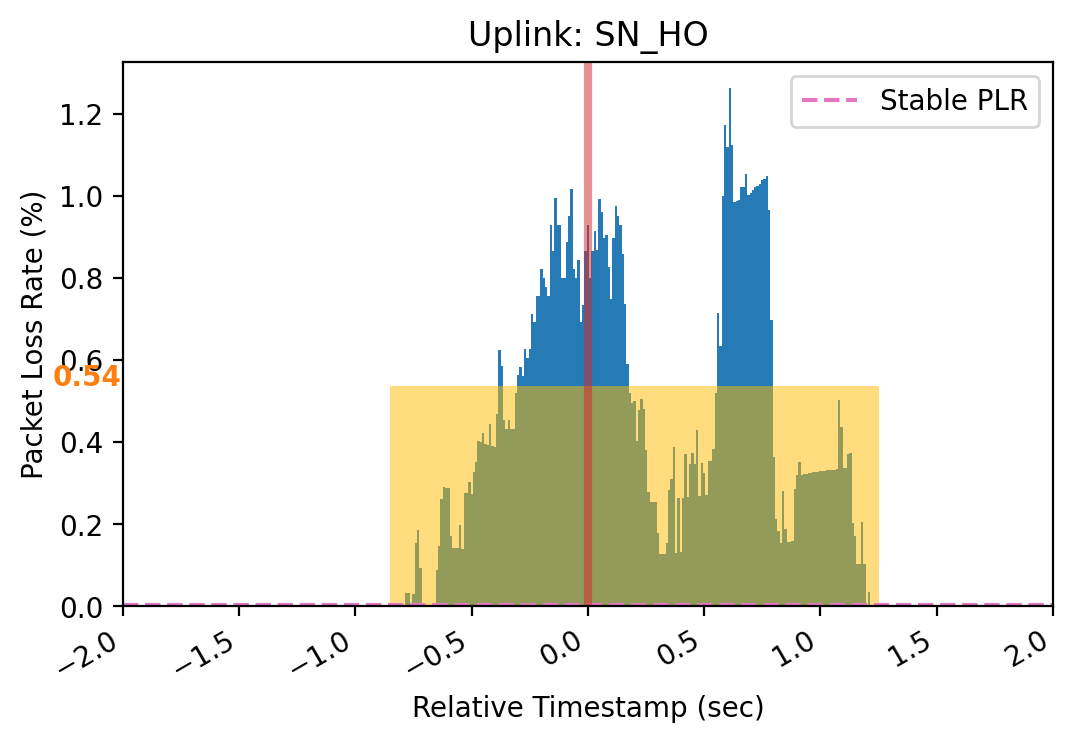

SN_Rel
Avg Duration: 0.02582324983086437 seconds
HO Count: 8
Avg PLR: 12.10045662097694 %


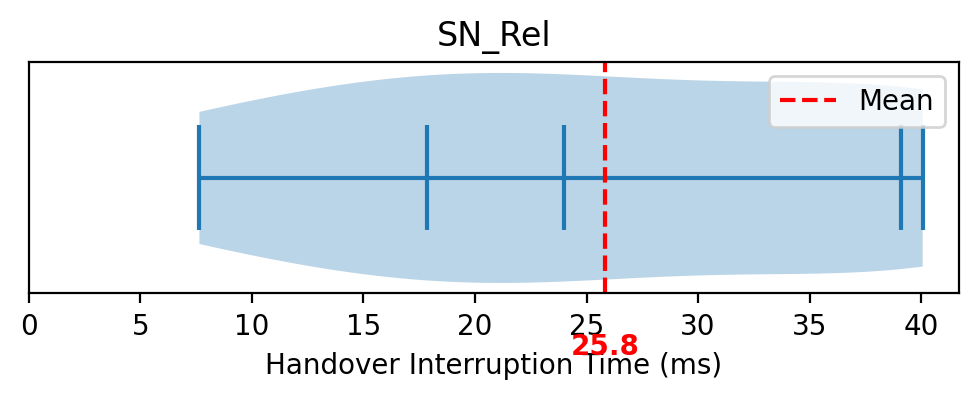

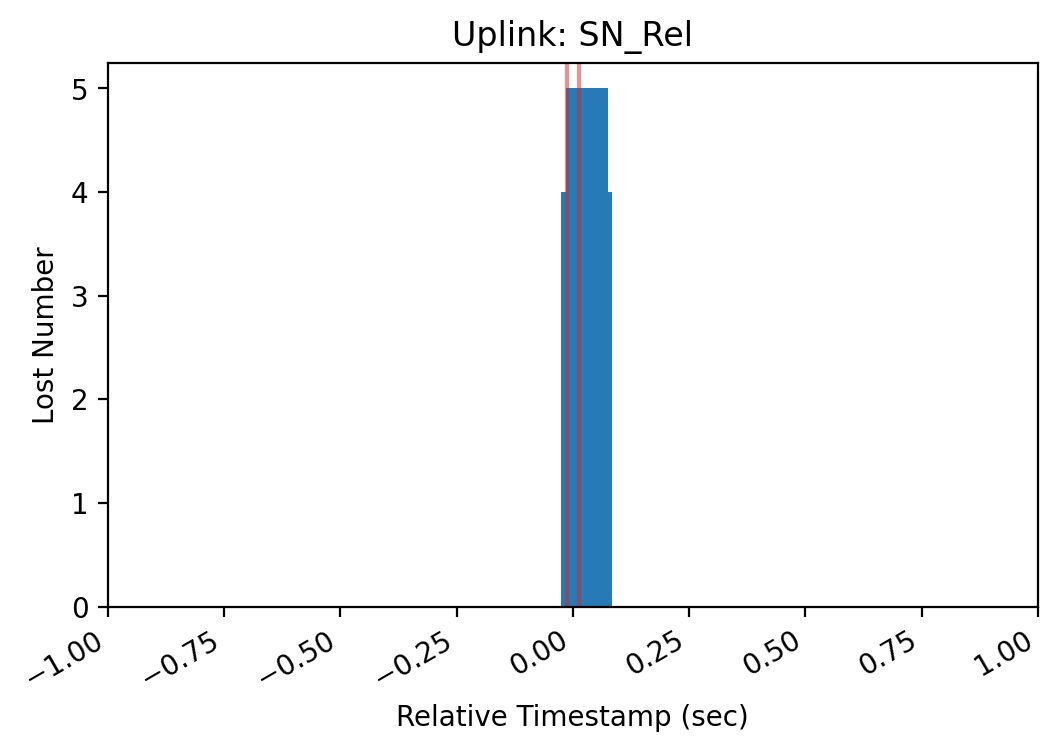

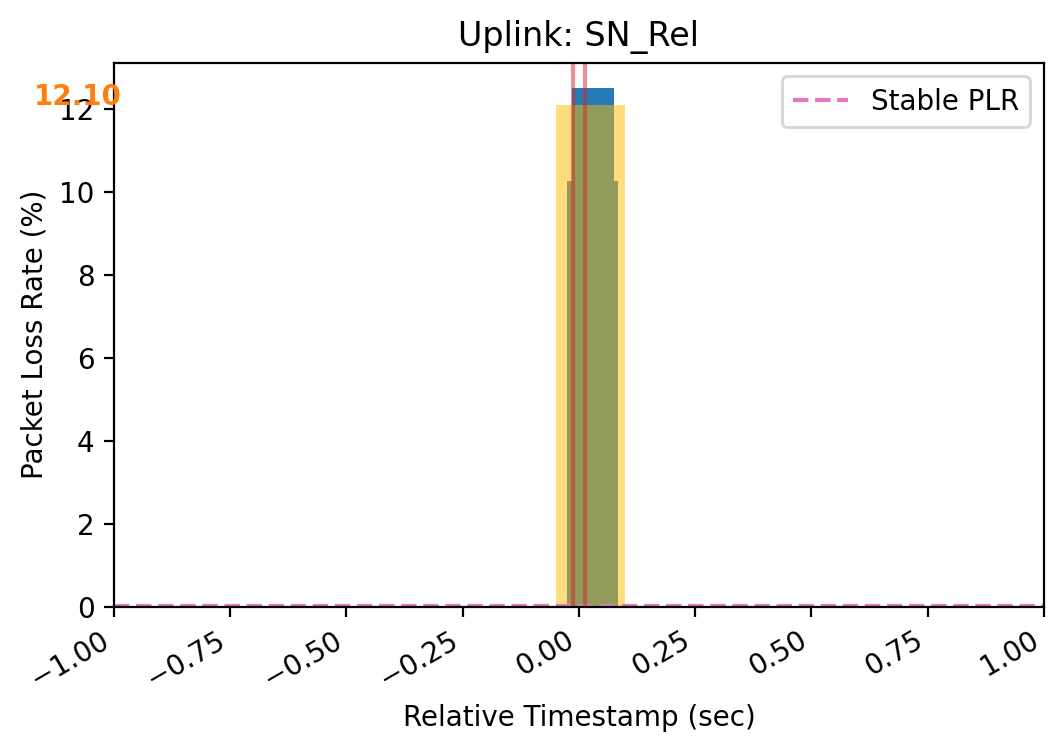

SN_Setup
Avg Duration: 0.028352583995276764 seconds
HO Count: 238
Avg PLR: 17.315779574948152 %


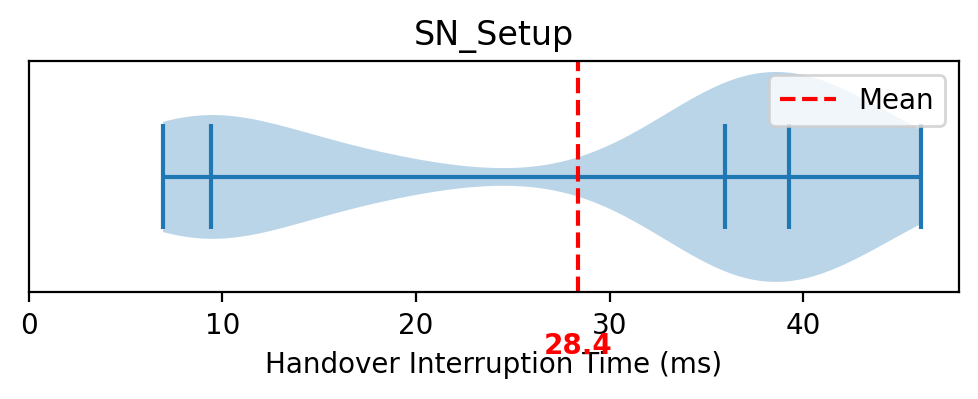

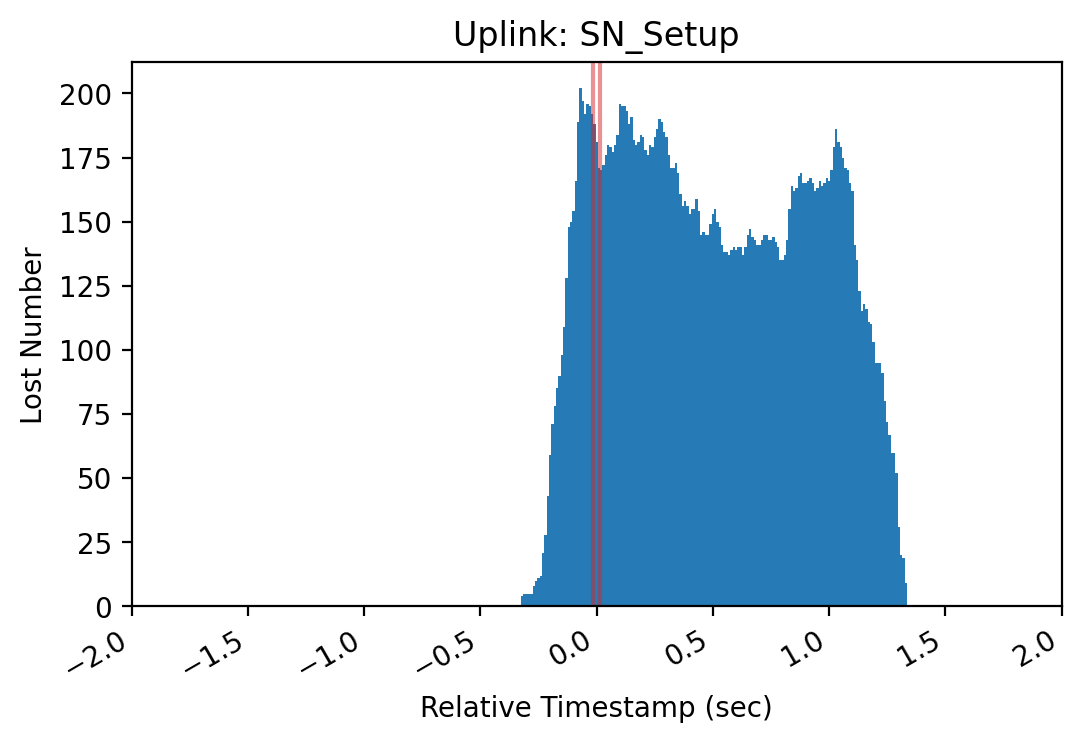

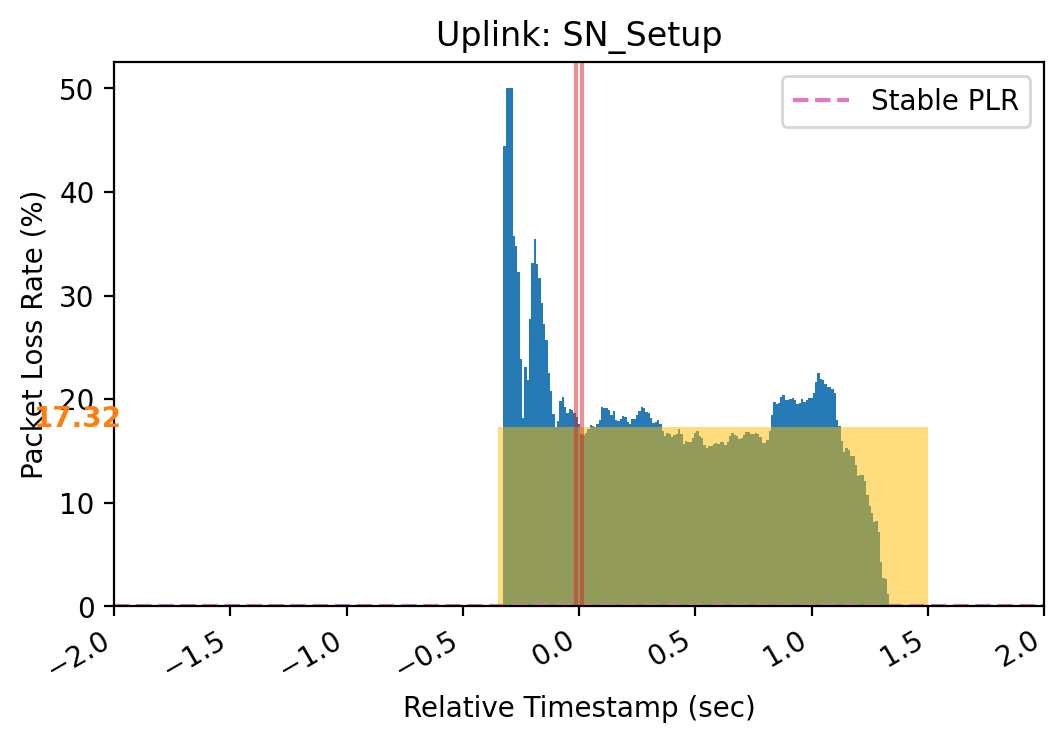

SN_Rel_MN_HO
Avg Duration: 0.016626903694914524 seconds
HO Count: 353
Avg PLR: 0.7004364027658699 %


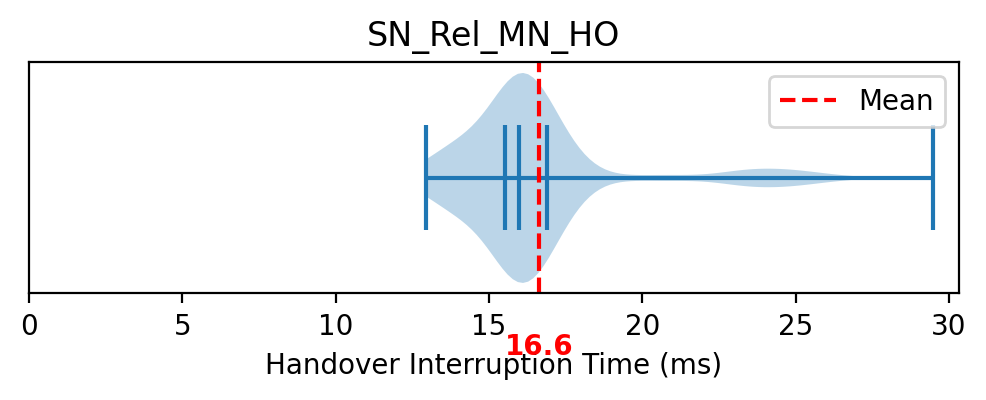

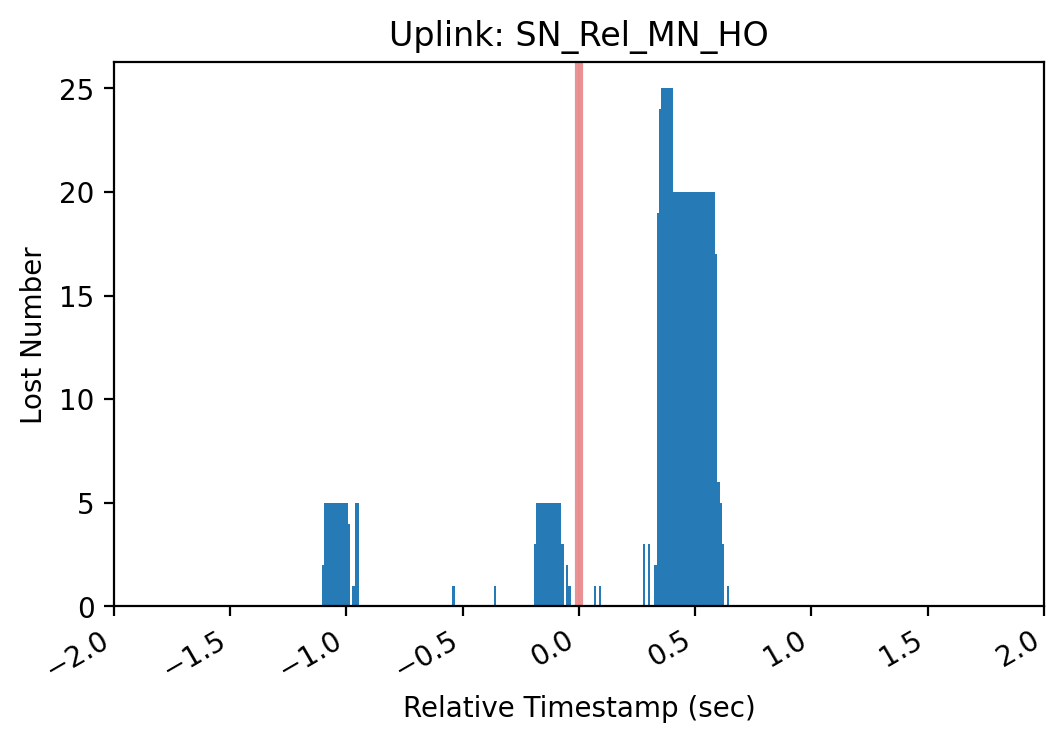

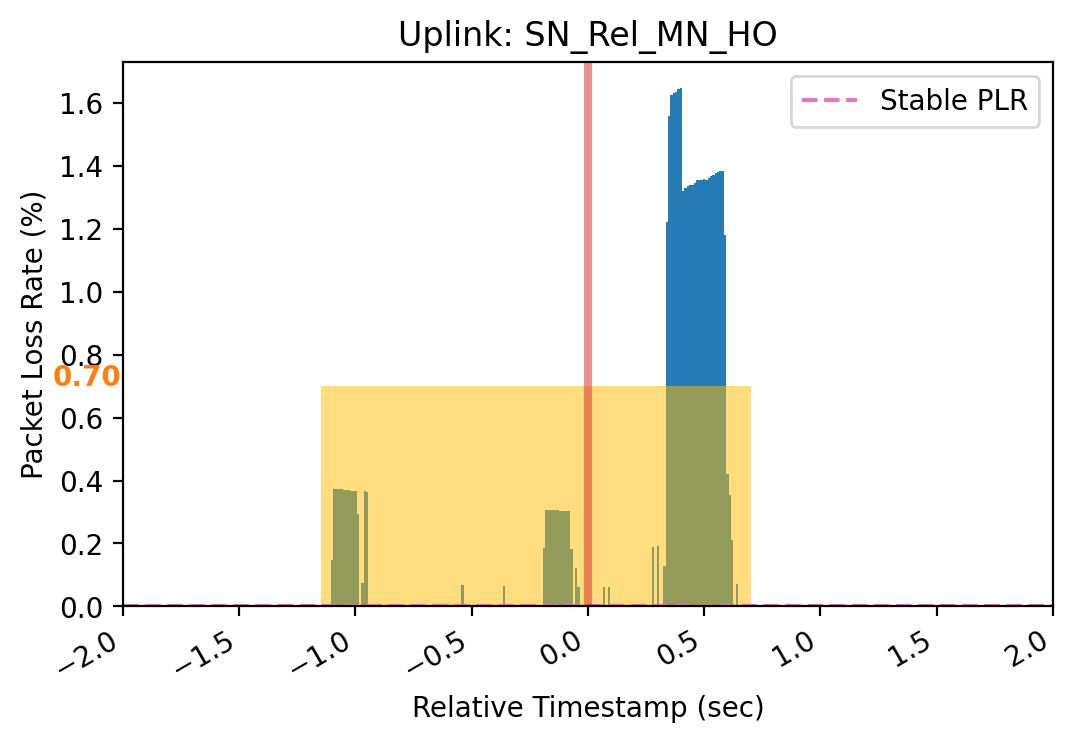

SCG_Failure_t310-Expiry (0)
Avg Duration: 0.0 seconds
HO Count: 3
Avg PLR: 66.87665782491152 %


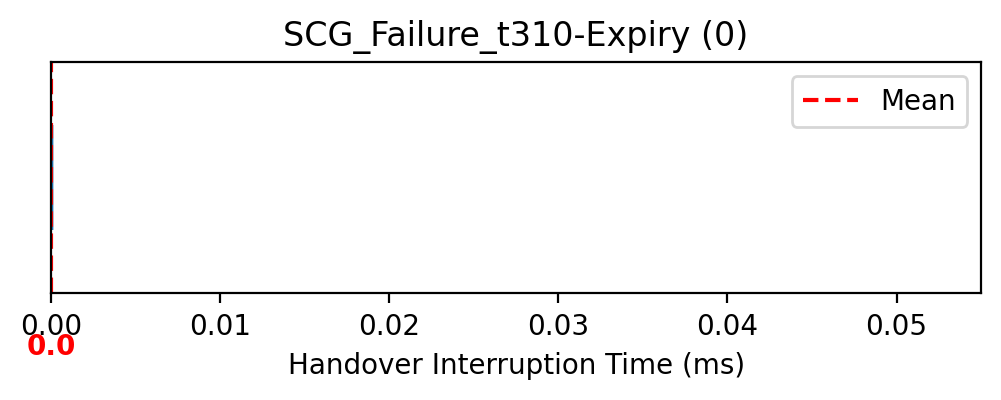

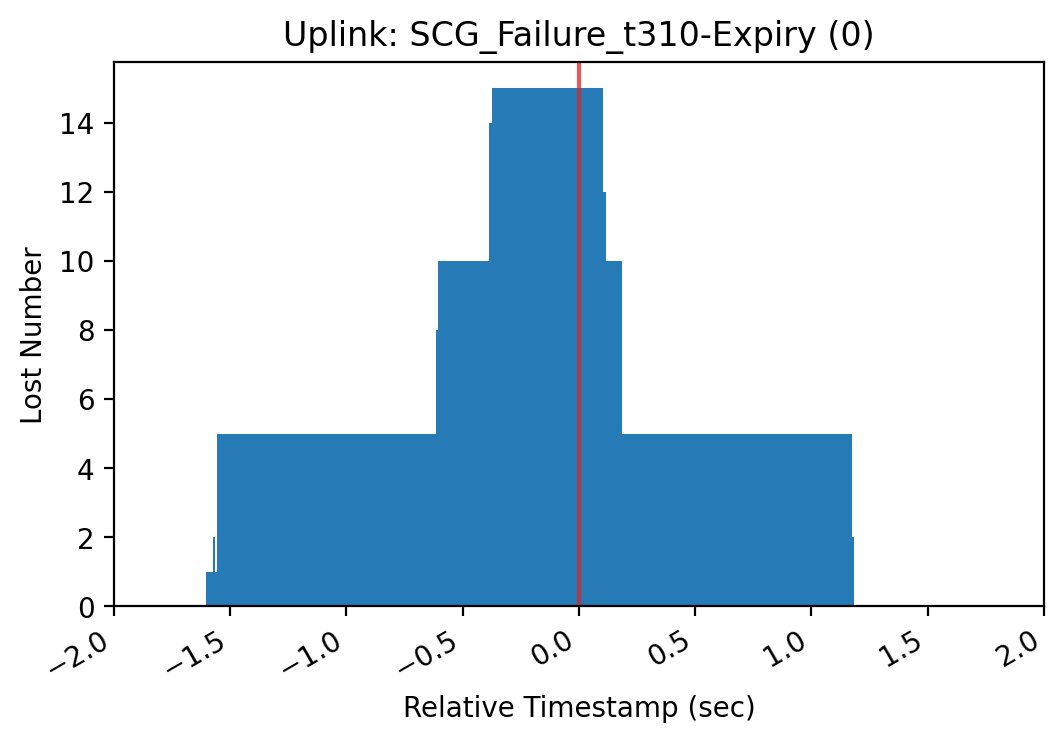

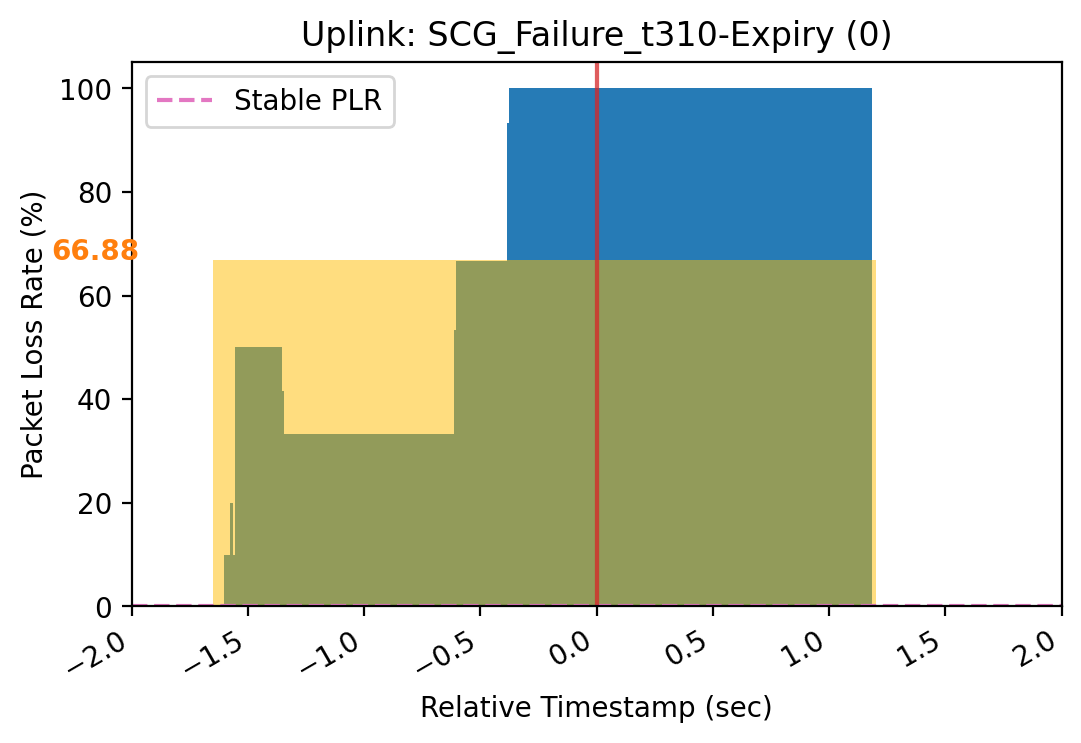

SCG_Failure_synchReconfigFailureSCG (3)
Avg Duration: 0.0 seconds
HO Count: 5
Avg PLR: 19.178082191649466 %


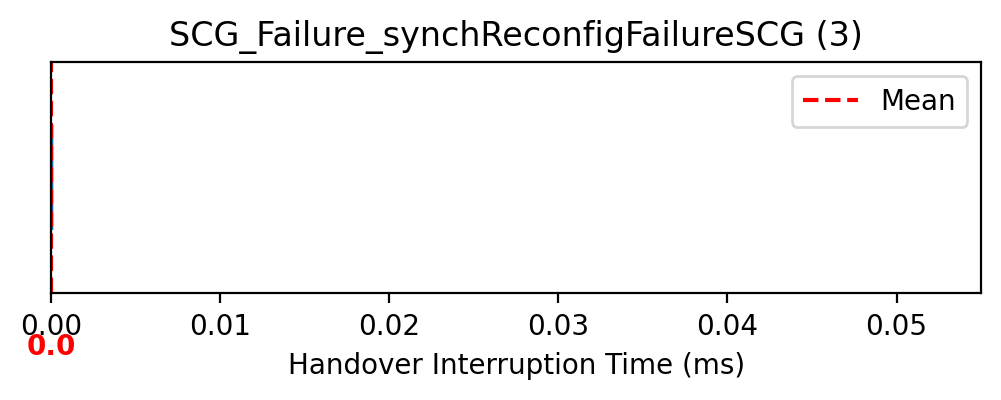

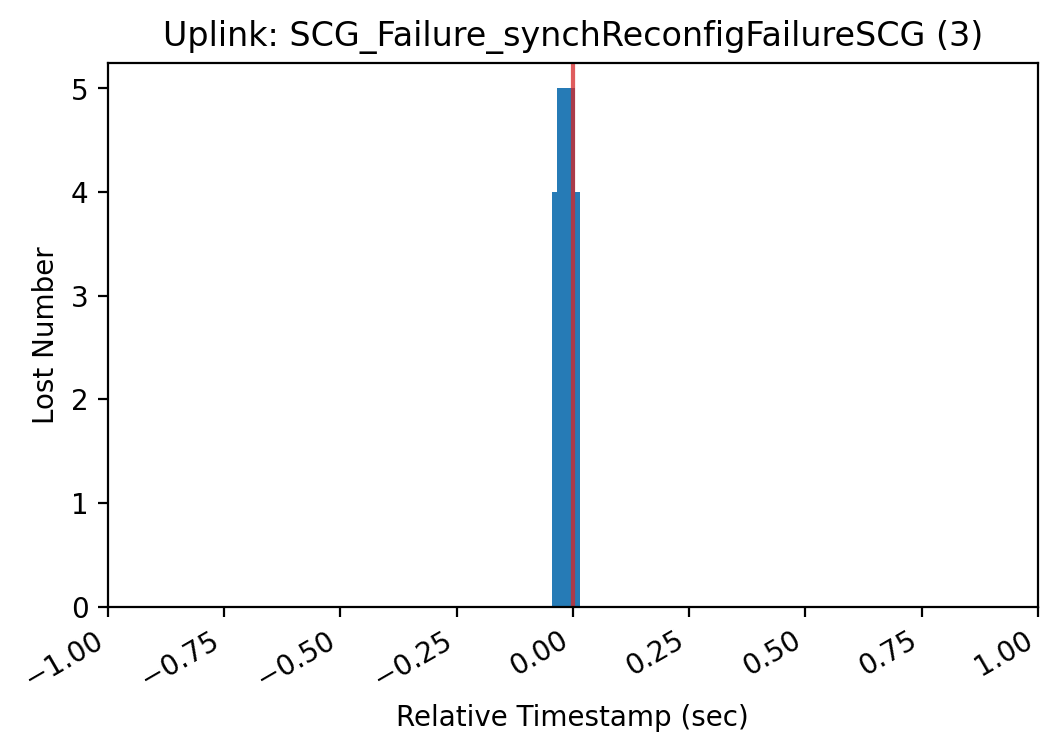

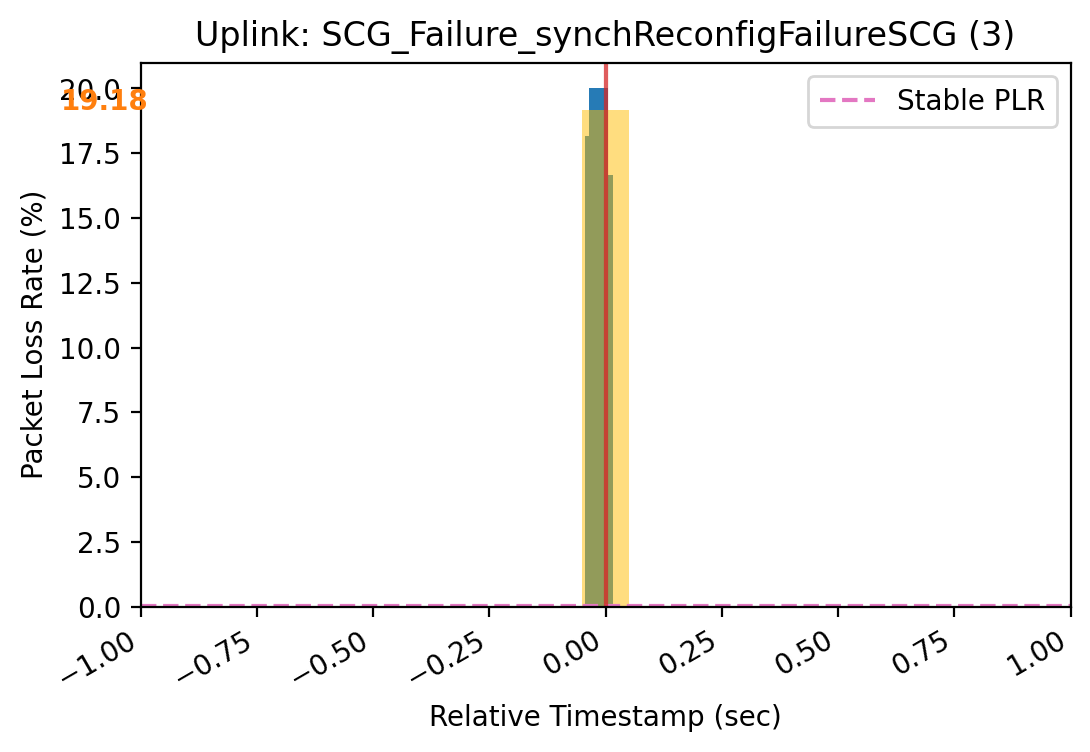

MCG_Failure_handoverFailure (1)
Avg Duration: 0.0812133003026247 seconds
HO Count: 10
Avg PLR: 59.18334409295365 %


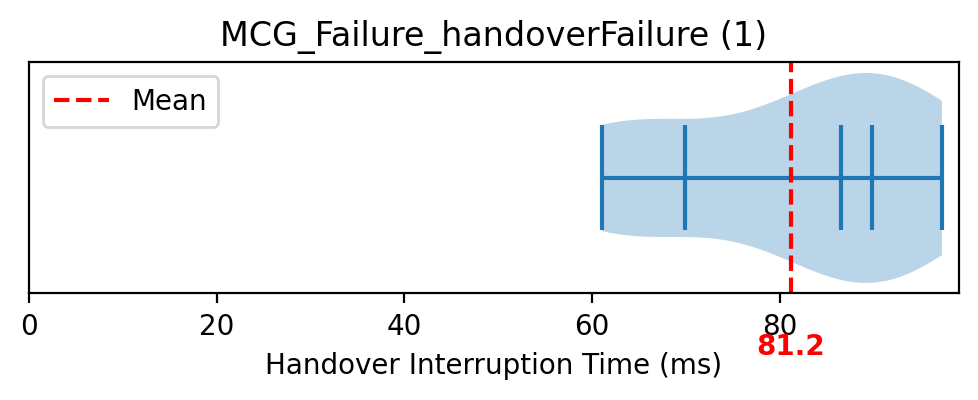

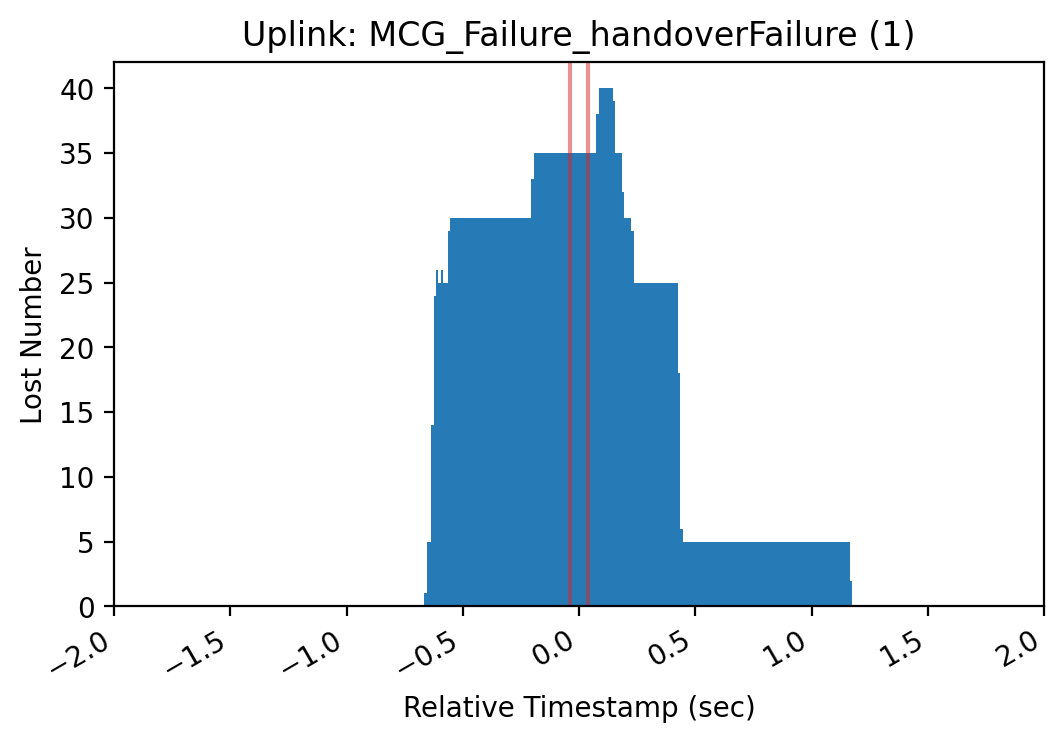

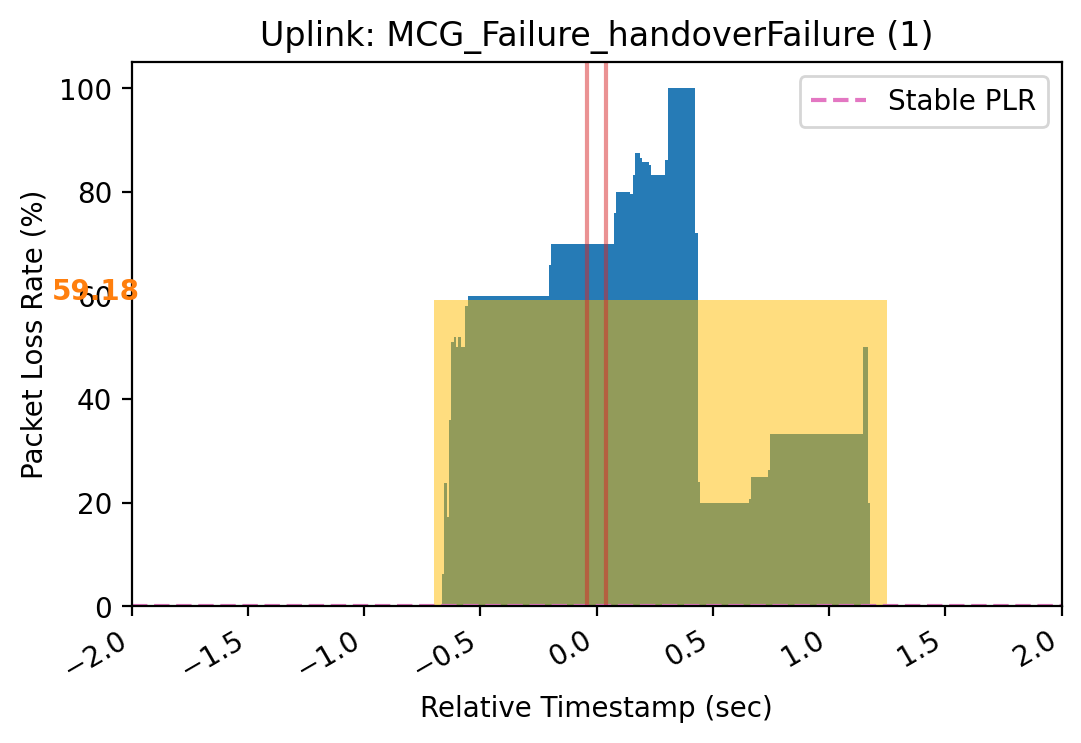

MCG_Failure_otherFailure (2)
Avg Duration: 0.07702575729350851 seconds
HO Count: 99
Avg PLR: 20.94828350926975 %


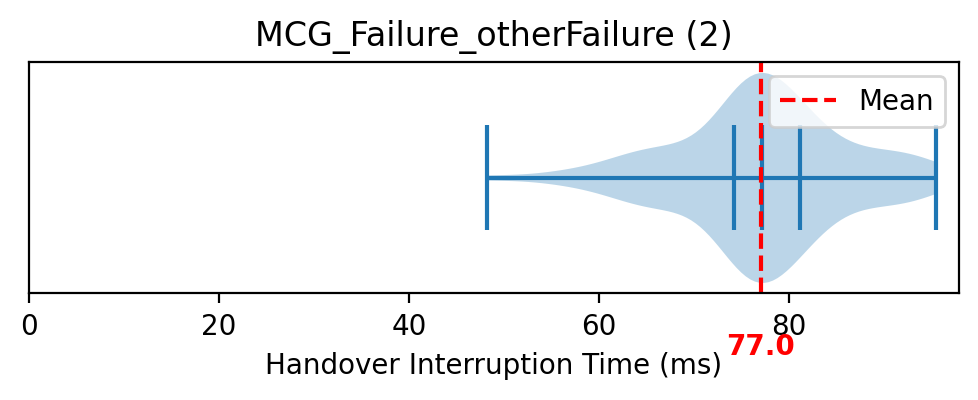

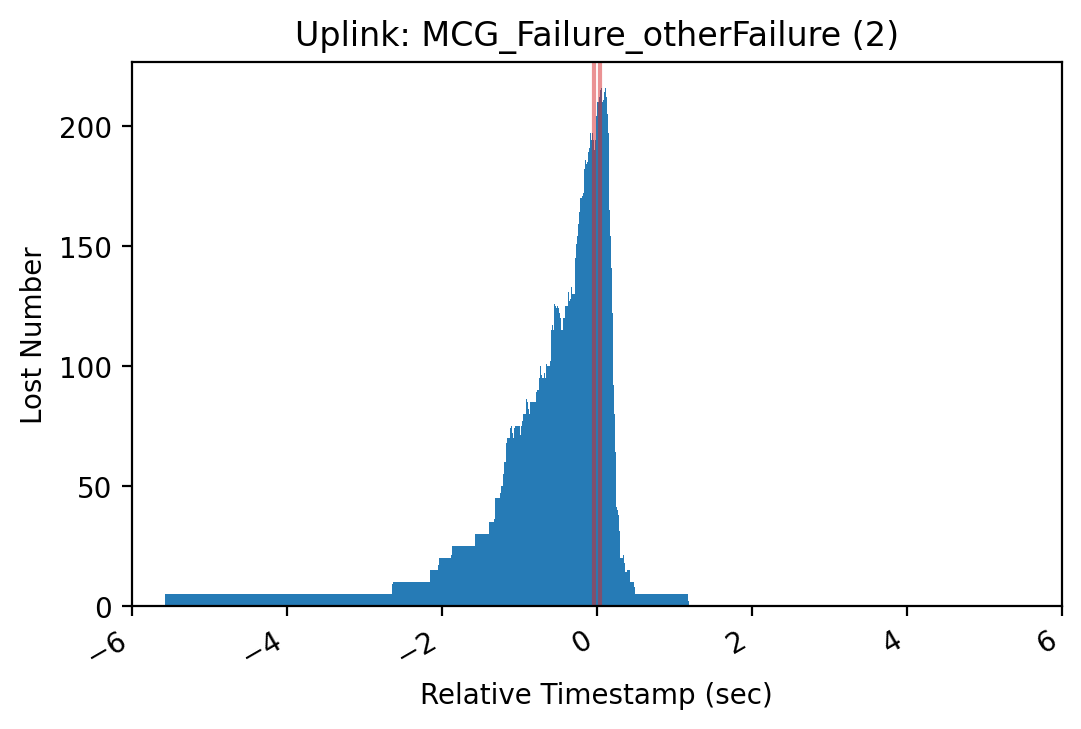

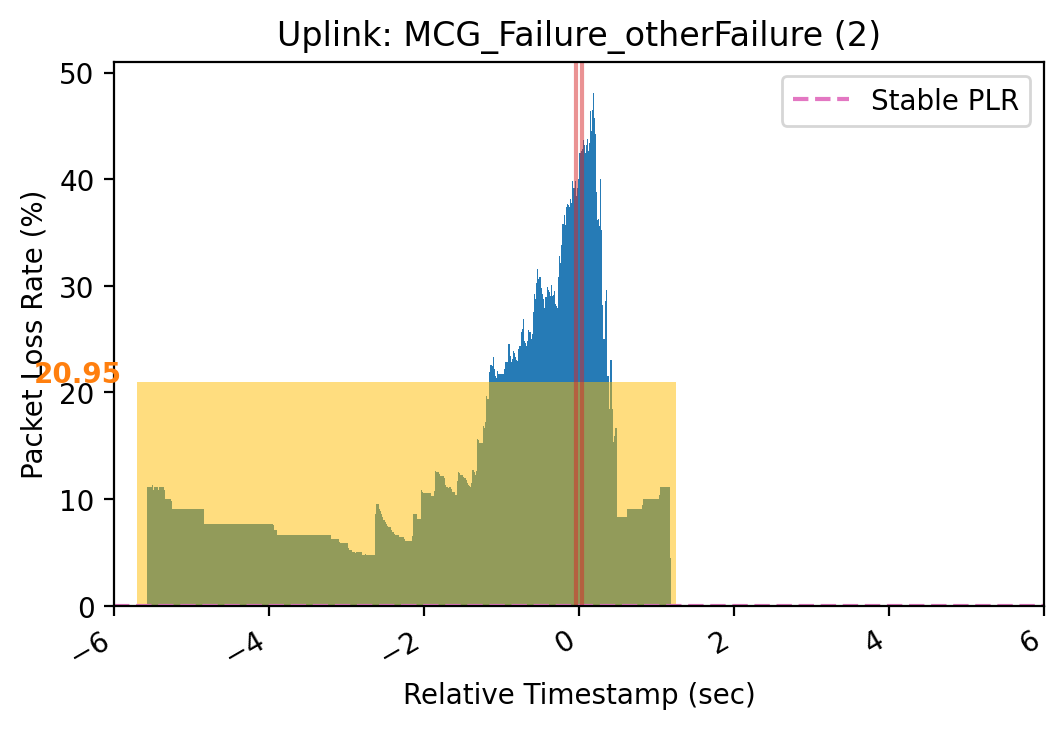

NAS_Recovery_otherFailure (2)
Avg Duration: 0.4677276611328125 seconds
HO Count: 3
Avg PLR: 85.77311868210941 %


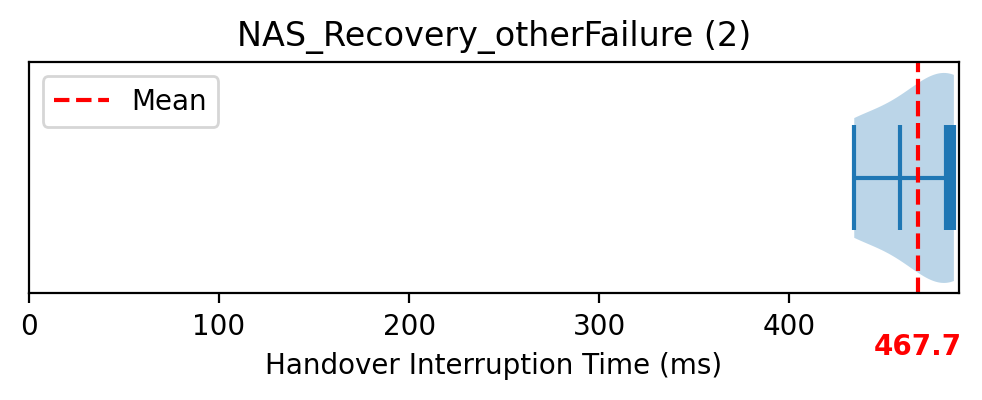

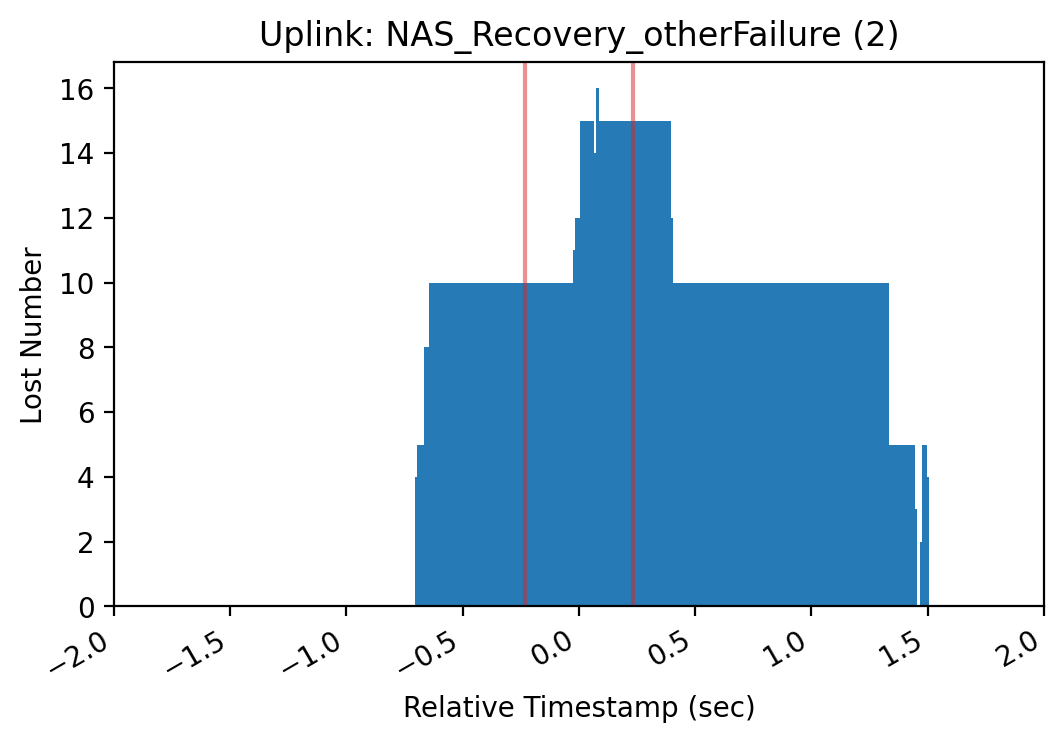

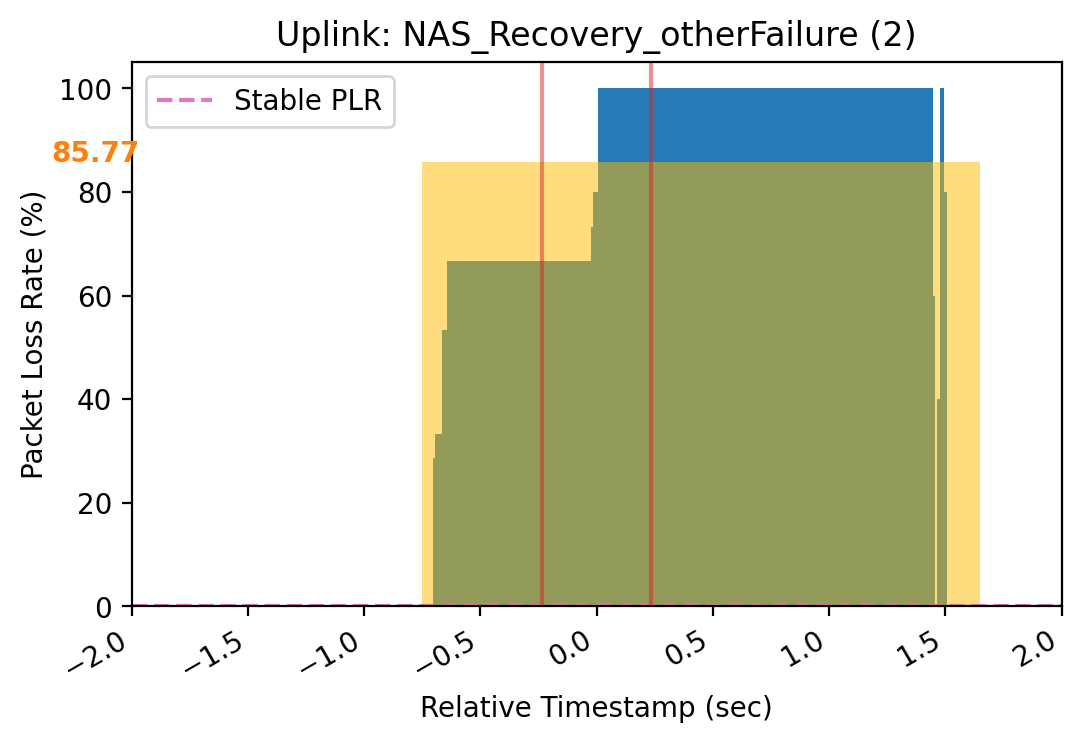

In [26]:
for tag in sorter:
    if len(D[tag]['intrs']) == 0:
        continue
    print('===================================')
    print(tag)
    table, intr = merge_profile(D[tag]['tables'], D[tag]['intrs'])
    print('Avg Duration:', intr, 'seconds')
    print('HO Count:', sum(D[tag]['count']))
    # display(table)
    # _table = table.query('lost > 0').copy().reset_index(drop=True)
    _table = table.query('PLR > @stable_plr').copy().reset_index(drop=True)
    tcount = sum(_table['tx_count'])
    lcount = sum(_table['lost'])
    plr = lcount / (tcount + 1e-9) * 100
    print('Avg PLR:', plr, '%')
    path = '/Users/jackbedford/Desktop/MOXA/2023-04-20/figure/'
    plot_intrs(D[tag]['intrs'], tag, path=path)
    wsize = math.ceil(max(ImpactScope[tag]))
    plot_profile(table, intr=intr, title=tag, mode='lost', xlim=wsize, path=path, flow='ul')
    plot_profile(table, intr=intr, title=tag, mode='plr', xlim=wsize, path=path, flow='ul', stable_plr=stable_plr, plr=plr)